In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify

ModuleNotFoundError: No module named 'squarify'

# Happiness

This notebook is purely an **exploratory data analysis** to see if I can figure out what makes a country happy or unhappy. To do this, I will be analysing & exploring the **World Happiness Index 2021, and the historic World Happiness Index scores from 2005.**

I hope to learn a few things along the way, and I hope anyone reading this will, too.

As an aside, I will bring in **population** data to investiagte if that has any obvious links to happiness levels.

I'll also explore if countries can improve their positions over time, or if the placings are more or less static.

**Finally**, I will formally cluster our data using K-means & the elbow method to see if we can group countires together based on their scores across the various metrics in the dataset.

In [3]:
#get data
import pandas as pd
pop = pd.read_csv('population_by_country_2020.csv')
df2 = pd.read_csv('world-happiness-report.csv')
df = pd.read_csv('world-happiness-report-2021.csv')


safety = df.copy()

# renaming columns for easier merge later
df.rename(columns={'Country name': 'Country'}, inplace=True)
df2.rename(columns={'Country name': 'Country'}, inplace=True)
pop.rename(columns={'Country (or dependency)': 'Country'}, inplace=True)

#might use later 
temporal = df2.groupby(['year','Country'])['Life Ladder'].mean().unstack().T
temporal = temporal.fillna(0).astype(int)

In [6]:
# colours
low_c = '#dd4124'
high_c = '#009473'
plt.rcParams["font.family"] = "monospace"

# Initial Overview

findfont: Font family ['sanserif'] not found. Falling back to DejaVu Sans.


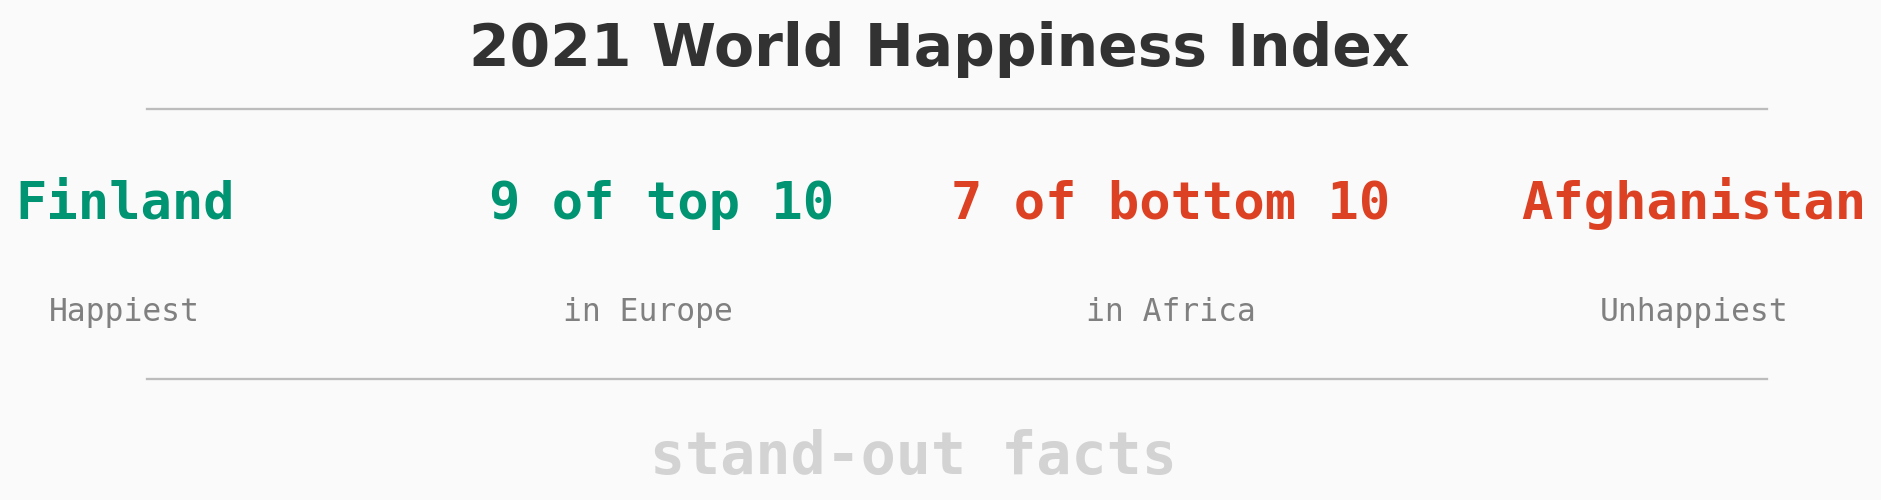

In [7]:
fig = plt.figure(figsize=(6,3),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(1.167,0.85,"2021 World Happiness Index",color='#323232',fontsize=28, fontweight='bold', fontfamily='sanserif',ha='center')
ax0.text(1.13,-0.35,"stand-out facts",color='lightgray',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')

ax0.text(0,0.4,"Finland",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.1,"Happiest",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(0.77,0.4,"9 of top 10",color=high_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0.75,0.1,"in Europe",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(1.5,0.4,"7 of bottom 10",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(1.5,0.1,"in Africa",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.text(2.25,0.4,"Afghanistan",color=low_c,fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.25,0.1,"Unhappiest",color='gray',fontsize=15, fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
import matplotlib.lines as lines
l1 = lines.Line2D([0.15, 1.95], [0.67, 0.67], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l1])
l2 = lines.Line2D([0.15, 1.95], [0.07, 0.07], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l2])
    
plt.show()

# What are the happiest countries in the world?

'Happiness' to me seems like an individual metric, something that is hard to generalise. However, some countries perform consistently well on the happiness index rankings. 

We've also noted that 9 of the top 10 are in Europe, and that 7 of the bottom 10 are in Africa.

Let's see which countries top the list currently, and those that are at the bottom.

In [12]:
past_winners = df2.loc[df2.groupby("year")["Life Ladder"].idxmax()]
past_bottom = df2.loc[df2.groupby("year")["Life Ladder"].idxmin()]

hap = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=False)[:10]
unhap = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=True)[:10]
top_bottom = hap.append(unhap, ignore_index=False).sort_values(ascending=True)

past_winners.head(10)

happ = df2.groupby('Country')['Life Ladder'].mean().sort_values(ascending=False)[:10]
unhapp = df2.groupby('Country')['Life Ladder'].mean().sort_values(ascending=True)[:10]
#top_bottom = hap.append(unhap, ignore_index=False).sort_values(ascending=True)

hap.head(10)

Country
Finland        7.842
Denmark        7.620
Switzerland    7.571
Iceland        7.554
Netherlands    7.464
Norway         7.392
Sweden         7.363
Luxembourg     7.324
New Zealand    7.277
Austria        7.268
Name: Ladder score, dtype: float64

In [15]:
u = df2.groupby('Country')['Life Ladder'].max().sort_values(ascending=False)[:50]
u.head(20)

Country
Denmark          8.019
Finland          7.889
Switzerland      7.776
Norway           7.678
Canada           7.650
Netherlands      7.631
Costa Rica       7.615
New Zealand      7.604
Iceland          7.591
Ireland          7.568
Sweden           7.560
United States    7.513
Austria          7.499
Venezuela        7.478
Australia        7.450
Mexico           7.443
Israel           7.433
Luxembourg       7.404
Panama           7.321
Germany          7.312
Name: Life Ladder, dtype: float64

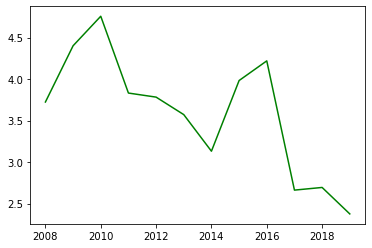

In [16]:
xy = df2['Country'].sort_values(ascending=False)[:10]
yx = df2['Life Ladder'].sort_values(ascending=False)[:10]
xy
#plt.plot(for plot in data:


data = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=False)[:10]
data

df2.head()
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
x = df2[df2['Country']== 'Afghanistan']['year']
y = df2[df2['Country']== 'Afghanistan']['Life Ladder']
plt.plot(x , y, 'g', label = 'Afghanistan')

Let's now view the top 10 and bottom 10 ...

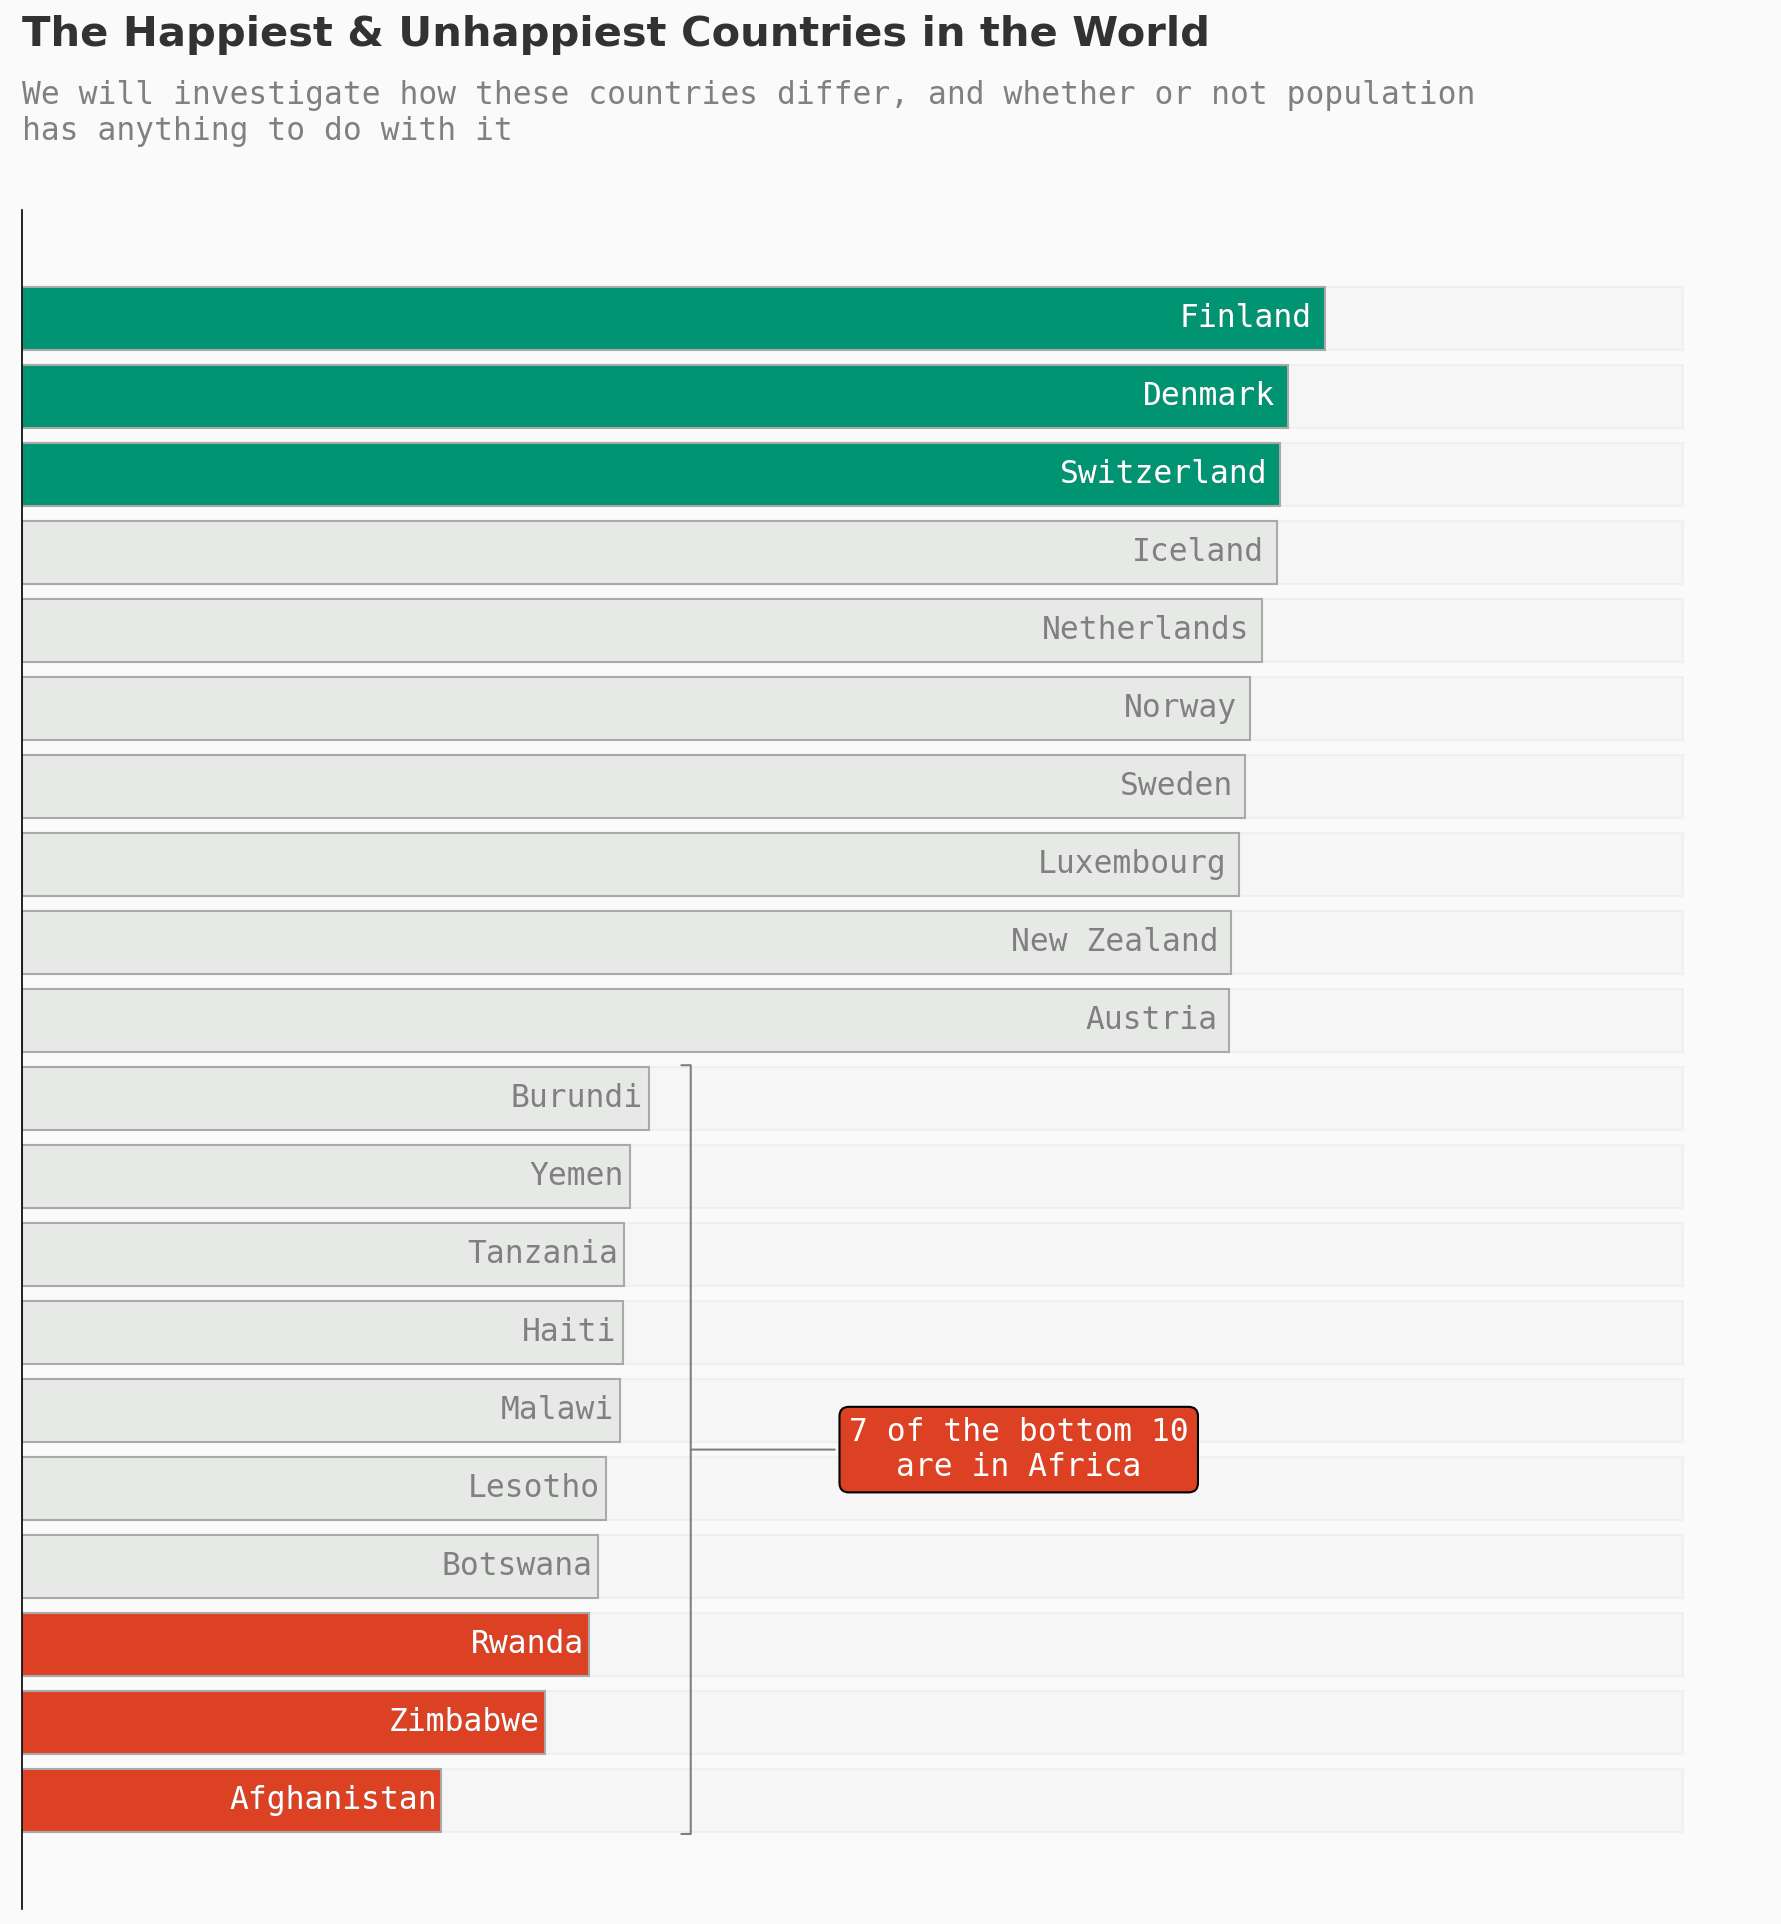

In [6]:
fig = plt.figure(figsize=(15,15),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


# Plots 
# Happiest
data = top_bottom

color_map = ['#e7e9e7' for _ in range(20)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight
color_map[17] = color_map[18] = color_map[19] =  high_c 
#base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)

for i in range(0,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)

for i in range(17,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])



for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
ax0.text(0,22.5,'The Happiest & Unhappiest Countries in the World',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,21.3,'We will investigate how these countries differ, and whether or not population\nhas anything to do with it',fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

ax0.annotate('7 of the bottom 10\nare in Africa', xy=(4, 4.5), xytext=(6, 4.5), xycoords='data', 
            fontsize=15, ha='center', va='center',fontfamily='monospace',
            bbox=dict(boxstyle='round', fc=low_c),
            arrowprops=dict(arrowstyle='-[, widthB=12.3, lengthB=0.3', lw=1, color='gray'), color='white')

plt.show()

Let's bring the top 10 & bottom 10 side-by-side now for an alternative view

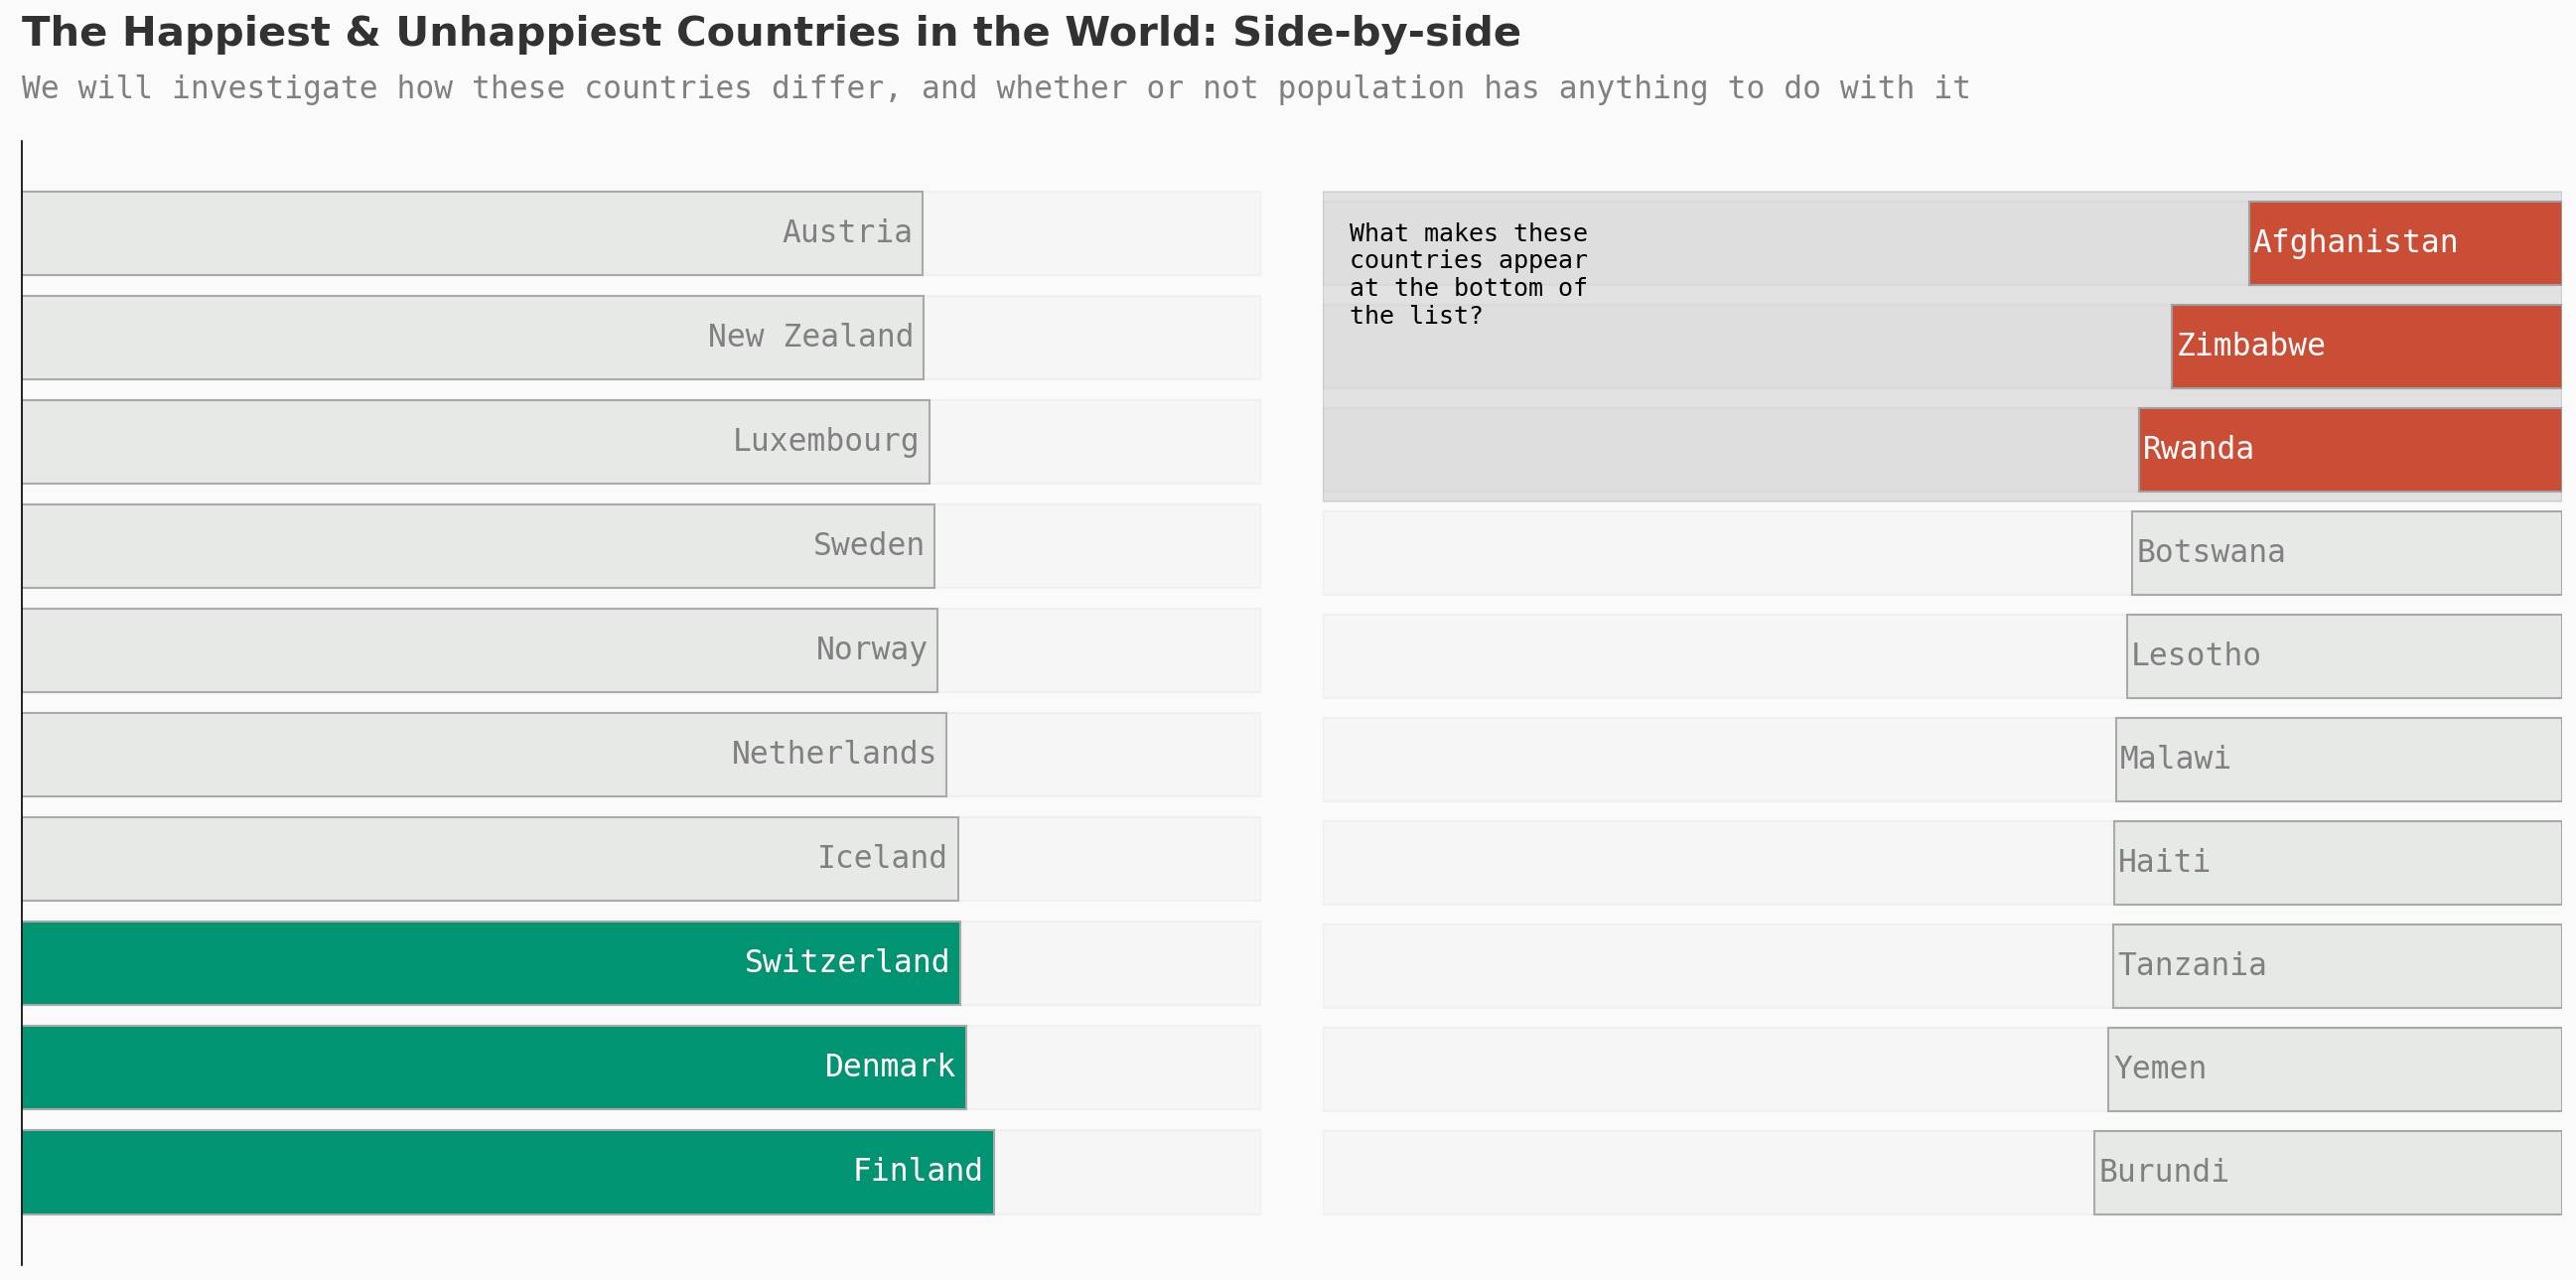

In [7]:
fig = plt.figure(figsize=(22,10),dpi=150)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 


# Plots 
# Happiest
data = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=False)[:10]


color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  high_c # color highlight

#base
ax0.barh(data.index, 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


#annotations
#for i in data.index:
 #   ax.annotate(f"{round(data[i],3)}", 
  #                 xy=(data[i] + 0.5,i), #i like to change this to roughly 5% of the highest cat
   #                va = 'center', ha='right',fontweight='light', fontfamily='serif',fontsize=12)
for i in range(0,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)
# diff color text
for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(data[i]-(data[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    
# Unhappiest

data = df.groupby('Country')['Ladder score'].mean().sort_values(ascending=True)[:10]

color_map = ['#e7e9e7' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight

#base
ax1.barh(data.index[::-1], 10, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax1.barh(data.index, data, 
       edgecolor='darkgray',color=color_map)


#annotations
#for i in data.index:
 #   ax.annotate(f"{round(data[i],3)}", 
  #                 xy=(data[i] + 0.5,i), #i like to change this to roughly 5% of the highest cat
   #                va = 'center', ha='right',fontweight='light', fontfamily='serif',fontsize=12)
for i in range(7,10):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
# diff color text
for i in range(0,7):
    ax1.annotate(list(data.index)[::-1][i], 
                   xy=(data[::-1][i]-(data[::-1][i]*0.01), i), 
                   va = 'center', ha='left',fontweight='light', fontfamily='monospace',fontsize=15, color='gray',rotation=0)

    


# Remove border from plot

for s in ['top', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
for s in ['top', 'bottom', 'right','left']:    
    ax1.spines[s].set_visible(False)
    


    
ax0.set_xlim(0,10)
ax1.set_xlim(10,0)
    
# ax labels off

ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])

ax0.text(0,10.8,'The Happiest & Unhappiest Countries in the World: Side-by-side',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
ax0.text(0,10.3,'We will investigate how these countries differ, and whether or not population has anything to do with it',fontfamily='monospace',fontsize=15,fontweight='light',color='gray')

# rect
from matplotlib.patches import Rectangle
X, Y = 0, 6.5


ax1.add_patch(Rectangle((X, Y), 10, 3,alpha=0.2, edgecolor='gray',facecolor='gray'))

fig.text(0.53,0.72,
        
'''
What makes these 
countries appear 
at the bottom of
the list?

''',color='black',fontfamily='monospace',fontsize=12)


plt.show()

At a glance, we see that many of the happiest countries in the world are indeed in Europe. 

An additional observation is that the countries in Europe in the top 10 are Northern European.

In [13]:
happiness_mean = df['Ladder score'].mean()

df['lower_happy'] = df['Ladder score'].apply(lambda x: 0 if x < happiness_mean else 1)
df['lower_happy'] 
df['Ladder score']

0      7.842
1      7.620
2      7.571
3      7.554
4      7.464
       ...  
144    3.512
145    3.467
146    3.415
147    3.145
148    2.523
Name: Ladder score, Length: 149, dtype: float64

# Is this the case often?

I will explore temporal change more in depth later, but for now, let's look at the **top 20 countries over the years**.

This plot shows all scores from 2005 through to the present for the top 20 countries, with their Mean score and their 2021 scores hihglighted specifically.

It's remarkable that many countries 2021 score is higher than their mean, despite the pandemic.

Although the scores do vary, they still remain relatively high.

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


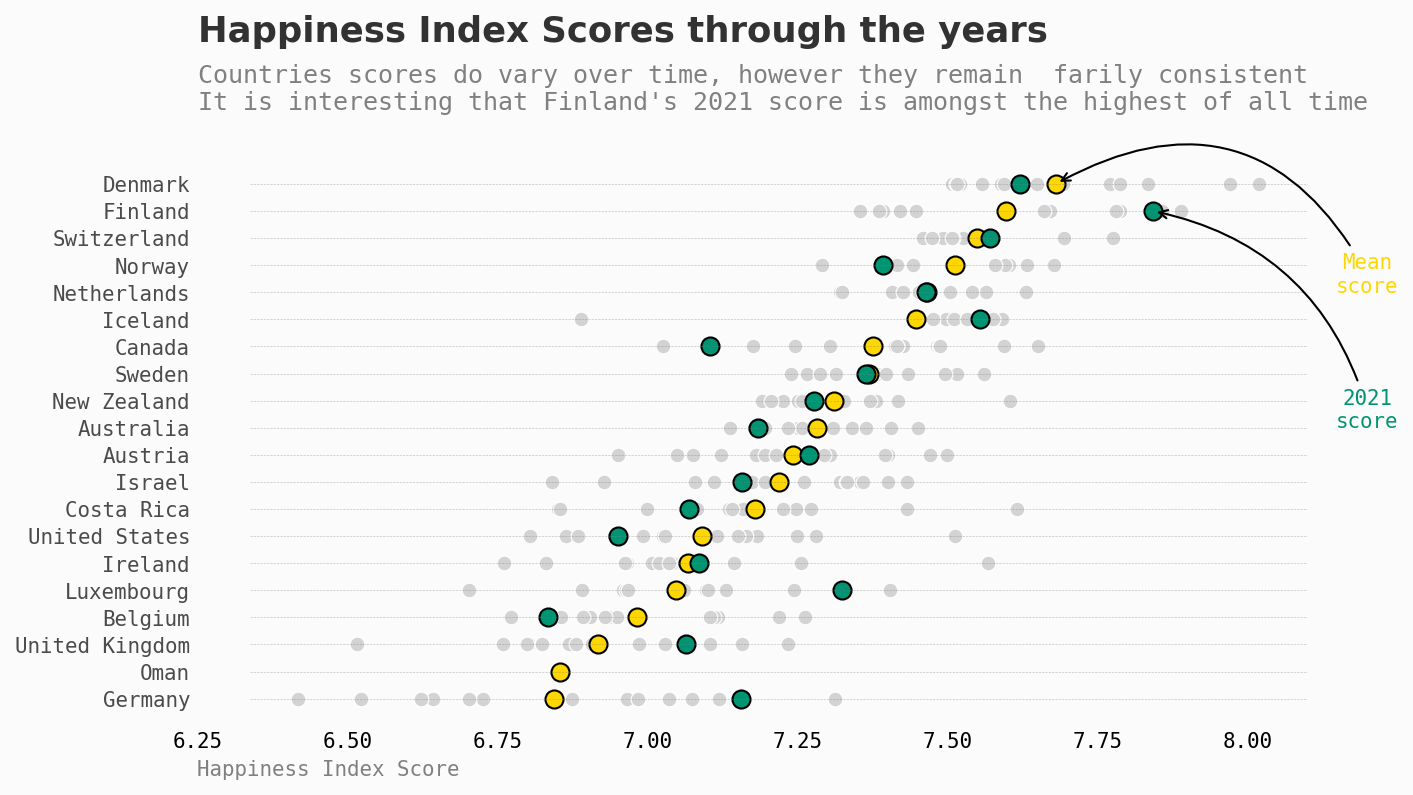

In [9]:

background = "#fbfbfb"
fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color
ax.set_facecolor(background)

# Reduced list as too many to show all at once 
top_list_ = df2.groupby('Country')['Life Ladder'].mean().sort_values(ascending=False).reset_index()[:20].sort_values(by='Life Ladder',ascending=True)


plot = 1
for country in top_list_['Country']:
    mean = df2[df2['Country'] == country].groupby('Country')['Life Ladder'].mean()
    # historic scores
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x='Life Ladder',color='lightgray',s=50,ax=ax)
    # mean score
    sns.scatterplot(data=df2[df2['Country'] == country], y=plot, x=mean,color='gold',ec='black',linewidth=1,s=75,ax=ax)
    #2021 score
    sns.scatterplot(data=df[df['Country'] == country], y=plot, x='Ladder score',color=high_c,ec='black',linewidth=1,s=75,ax=ax)   
    plot += 1


ax.set_yticks(top_list_.index+1)
ax.set_yticklabels(top_list_['Country'][::-1], fontdict={'horizontalalignment': 'right'}, alpha=0.7)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel("Happiness Index Score",fontfamily='monospace',loc='left',color='gray')


for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
Xstart, Xend = ax.get_xlim()
Ystart, Yend = ax.get_ylim()

ax.hlines(y=top_list_.index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
ax.set_axisbelow(True)
ax.text(6.25, Yend+4.3, 'Happiness Index Scores through the years', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax.text(6.25, Yend+0.75,
'''
Countries scores do vary over time, however they remain  farily consistent
It is interesting that Finland's 2021 score is amongst the highest of all time
''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.annotate('2021\nscore', xy=(7.842, 19), xytext=(8.2, 11),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.3"), fontsize=10,fontfamily='monospace',ha='center', color=high_c)

plt.annotate('Mean\nscore', xy=(7.6804, 20), xytext=(8.2, 16),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.5"), fontsize=10,fontfamily='monospace',ha='center', color='gold')


plt.show()

# Why are there differences?

We now understand that Northern European nations top the list, and have done for some time.

Let's explore these differences between Europe and the rest of the world a little more closely.

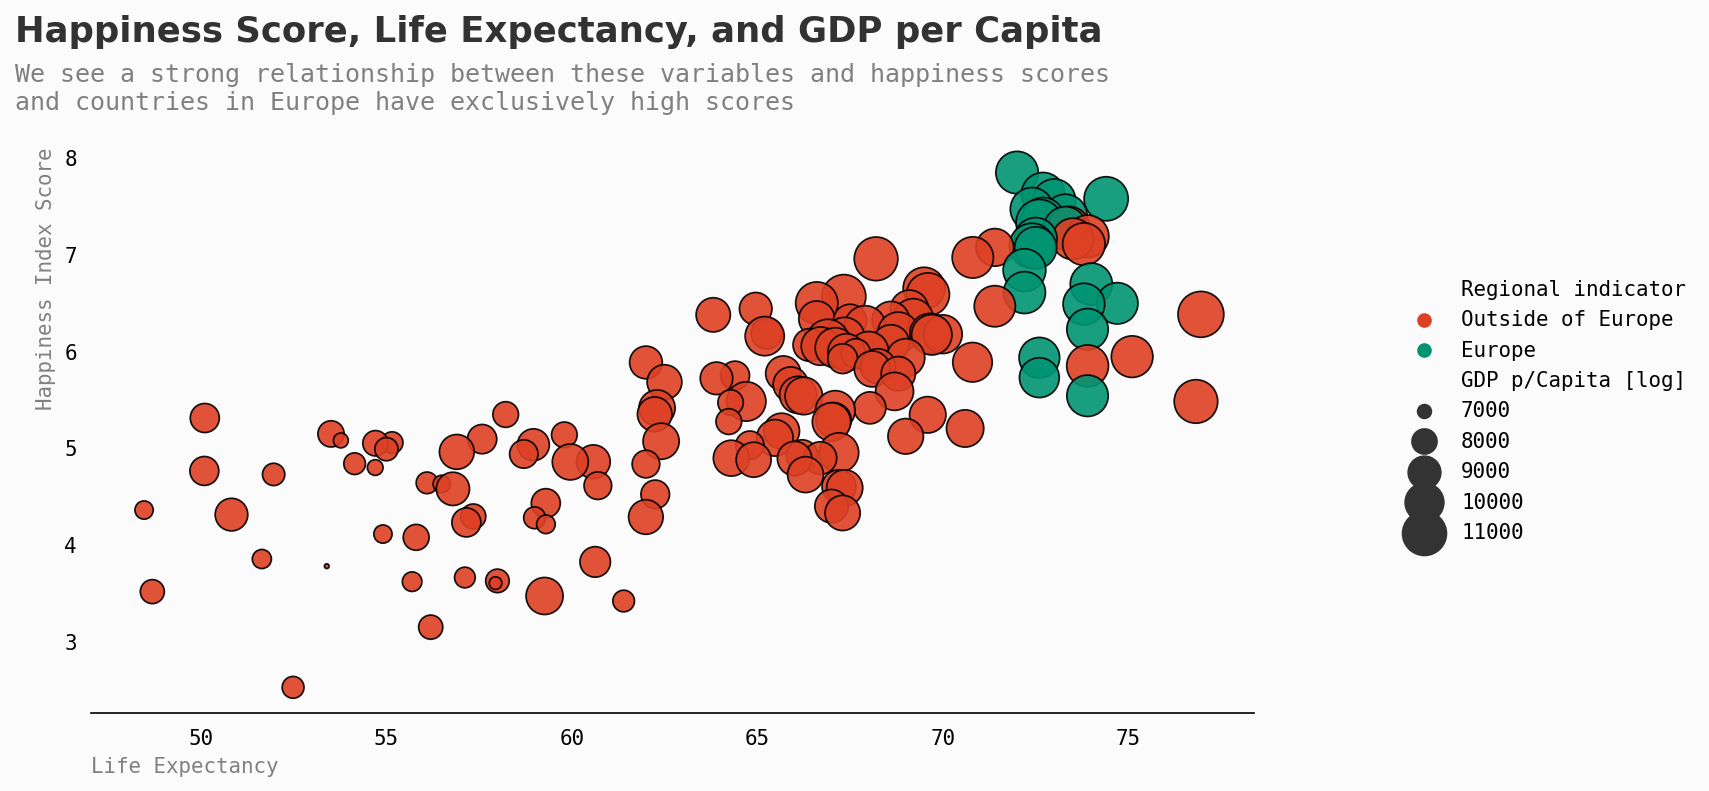

In [10]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Healthy life expectancy', y='Ladder score',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',size=df["Logged GDP per capita"]*1000, legend=True, sizes=(5, 500))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(45,9.2,'Happiness Score, Life Expectancy, and GDP per Capita',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(45,8.5,'We see a strong relationship between these variables and happiness scores\nand countries in Europe have exclusively high scores',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('GDP p/Capita [log]')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

Happier countries tend to be those with longer life expectancies, and a higher GDP. This is also most of Western Europe.

Let's explicitly highlight Africa now...

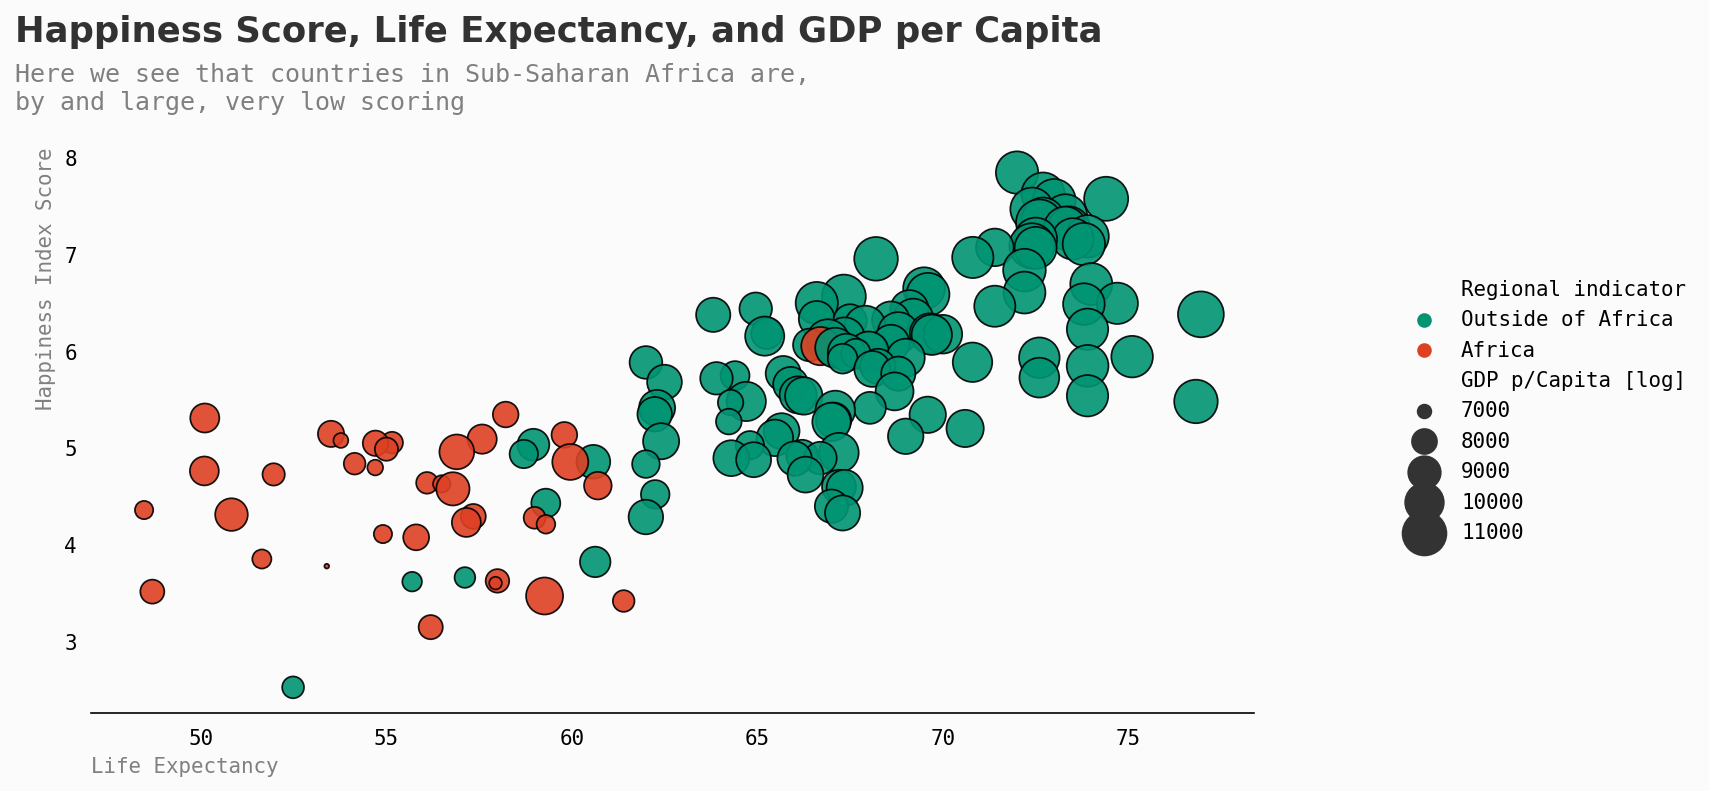

In [11]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [high_c,low_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Healthy life expectancy', y='Ladder score',hue=df['Regional indicator'] == 'Sub-Saharan Africa',palette=cmap, alpha=0.9,ec='black',size=df["Logged GDP per capita"]*1000, legend=True, sizes=(5, 500))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(45,9.2,'Happiness Score, Life Expectancy, and GDP per Capita',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(45,8.5,'Here we see that countries in Sub-Saharan Africa are,\nby and large, very low scoring',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')



L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Africa')
L.get_texts()[2].set_text('Africa')
L.get_texts()[3].set_text('GDP p/Capita [log]')

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

By and large, African countries have lower life expectancy, a lower GDP, and ultimately, lower happiness index scores.

# Other factors

So GDP & Life expactancy are factors. What else can be considered?

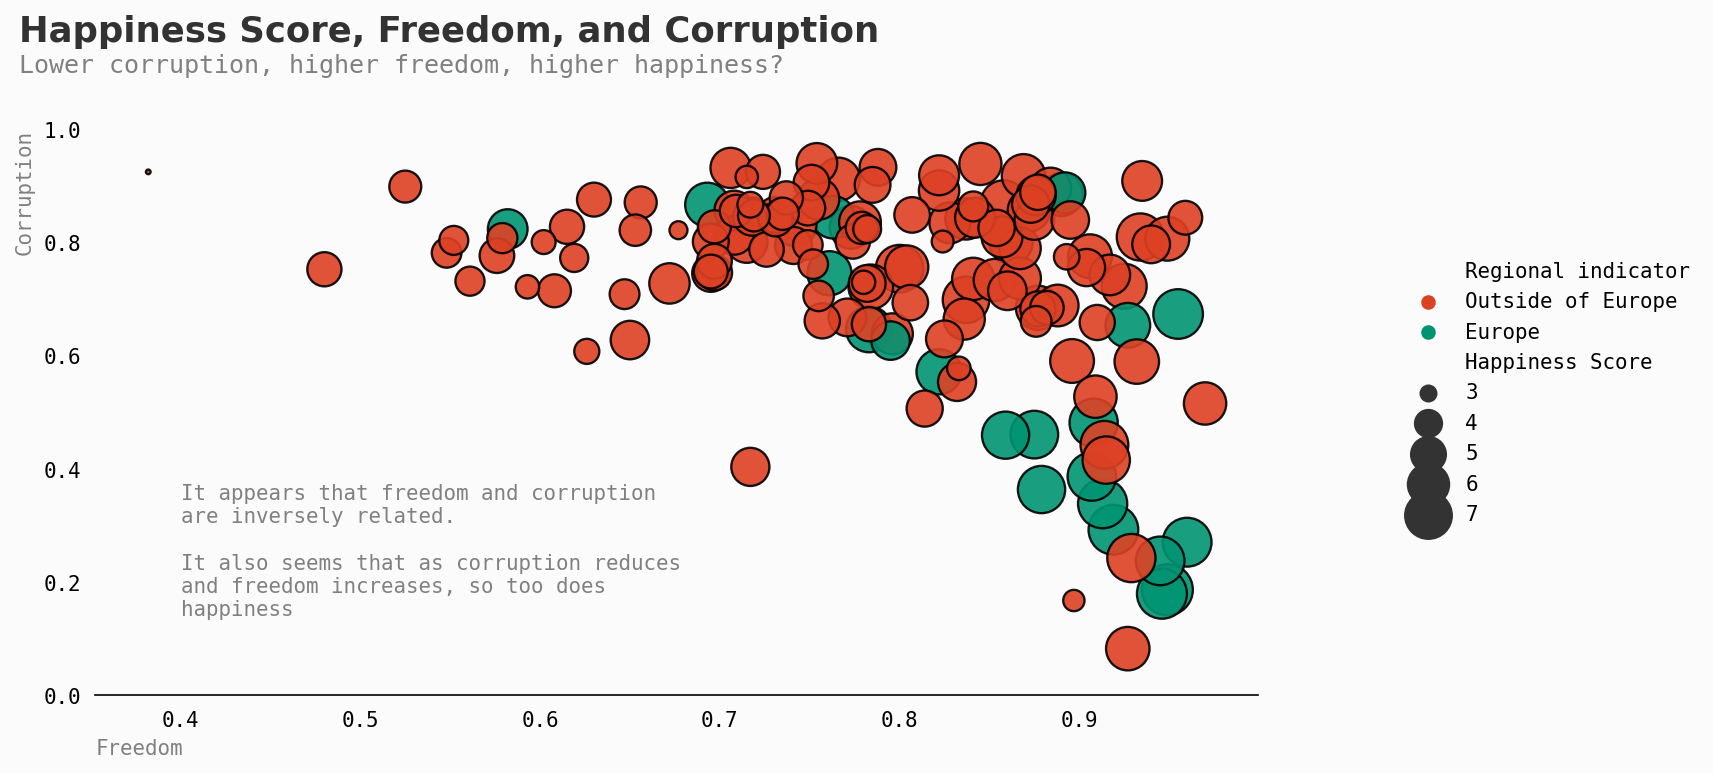

In [12]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Freedom to make life choices', y='Perceptions of corruption',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',size=df["Ladder score"], legend=True, sizes=(5, 600))

ax.set_xlabel("Freedom",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Corruption",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Happiness Score')

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end+0.2, 0.2))



ax.text(0.31,1.155,'Happiness Score, Freedom, and Corruption',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(0.31,1.1,'Lower corruption, higher freedom, higher happiness?',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

ax.text(0.4,0.1,
'''
It appears that freedom and corruption
are inversely related. 

It also seems that as corruption reduces
and freedom increases, so too does
happiness
''',fontfamily='monospace',fontsize=10,color='gray')

plt.show()

As I have noted in the plot, Freedom & Corruption are inversely related: higher corruption tends to be accompanied by lower freedom.

However, it is interesting to note that several European nations have high percieved levels of corruption too.


# A Continental view

Let's wrap the countries up in to their respective continents to see if we can learn more.

Of course we expect Western Europe to be high, but are there any other continents that perform particularly well or poorly in the happiness rankings?

No handles with labels found to put in legend.


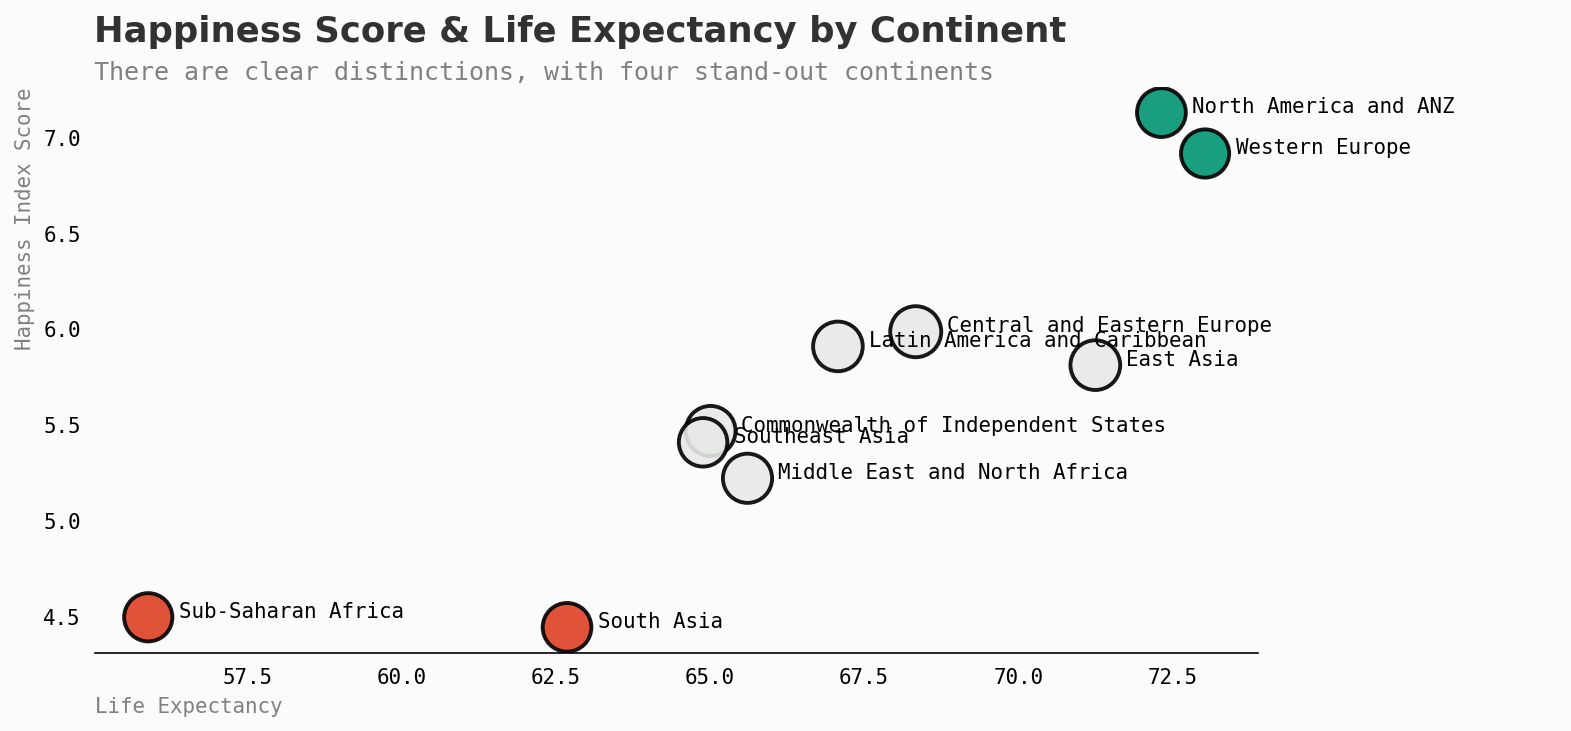

In [13]:

continent_score = df.groupby('Regional indicator')['Healthy life expectancy','Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Ladder score'].mean().reset_index()

background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]


color_map = ['#e7e9e7' for _ in range(10)]
color_map[9] =  high_c # color highlight
color_map[5] =  high_c
color_map[8] =  low_c
color_map[6] =  low_c


ax.set_facecolor(background)
sns.scatterplot(data=continent_score, x=continent_score['Healthy life expectancy'], y=continent_score['Ladder score'],hue=continent_score['Regional indicator'], alpha=0.9,ec='black',palette=color_map,size=df["Ladder score"], legend=False, sizes=(5, 600))

ax.set_xlabel("Life Expectancy",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
    
ax.text(55,7.5,'Happiness Score & Life Expectancy by Continent',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(55,7.3,'There are clear distinctions, with four stand-out continents',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')



L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

for i, txt in enumerate(continent_score['Regional indicator']):
    ax.annotate(txt, (continent_score['Healthy life expectancy'][i]+0.5, continent_score['Ladder score'][i]),fontfamily='monospace')


    
plt.show()

There are **three clusters** of continents that are clear to see. **More on this later...**

Sub-Saharan Africa & South Asia have the lowest scores. Whilst Western Europe and North America & ANZ are far ahead at the top.

In [14]:
continent_score = df.groupby('Regional indicator')['Healthy life expectancy','Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Ladder score'].mean().reset_index().mean().sort_values(ascending=True)[:10]
df_bottom = df.groupby('Country')['Logged GDP per capita','Perceptions of corruption','Freedom to make life choices','Social support','Ladder score'].mean().sort_values(by='Ladder score',ascending=True)[:10]

df_bottom['Logged GDP per capita'] = df_bottom['Logged GDP per capita']/10
df_bottom['Ladder score'] = df_bottom['Ladder score']/5

categorical = [var for var in df.columns if df[var].dtype=='O']
continuous = [var for var in df.columns if df[var].dtype!='O']

#refined
continuous = ['Logged GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

# Differences between those above & below the mean happiness level

Let's plot all many features at once, split by the mean happiness level. The happiest countries are, as always, shown in green.

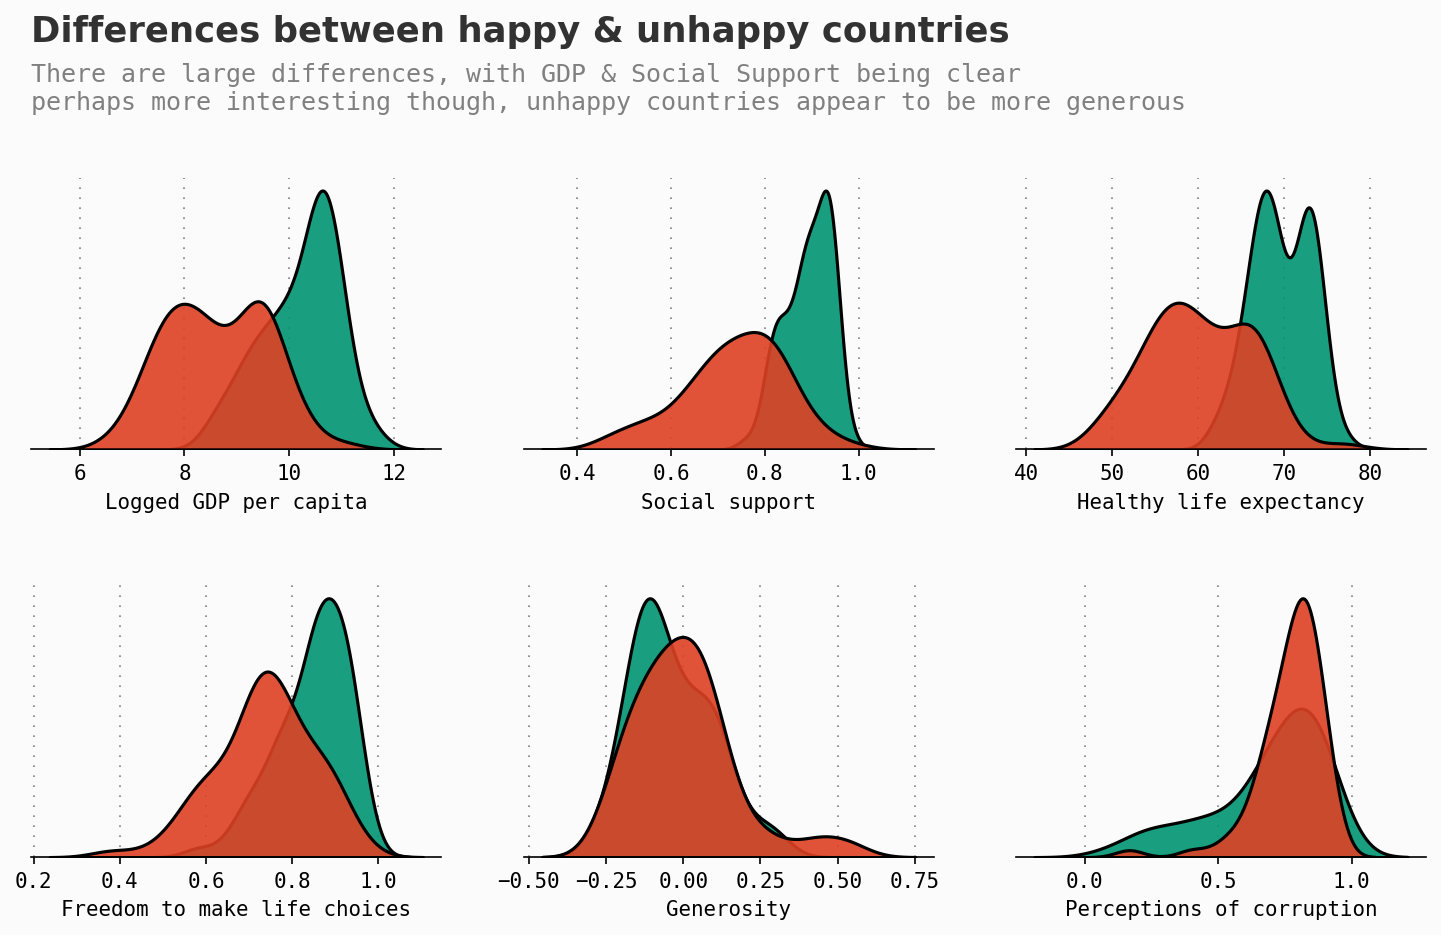

In [15]:
background_color = '#fbfbfb'
fig = plt.figure(figsize=(12, 6), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.5)


plot = 0
for row in range(0, 2):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

Yes = df[df['lower_happy'] == 1]
No = df[df['lower_happy'] == 0]

for variable in continuous:
        sns.kdeplot(Yes[variable], ax=locals()["ax"+str(plot)], color=high_c,ec='black', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(No[variable],ax=locals()["ax"+str(plot)], color=low_c, shade=True, ec='black',linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable, fontfamily='monospace')
        plot += 1
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.5), 'Differences between happy & unhappy countries', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax0.text(Xstart, Yend+(Yend*0.25), 'There are large differences, with GDP & Social Support being clear\nperhaps more interesting though, unhappy countries appear to be more generous', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.show()

The plots above confirm what we saw earlier, with some notable features such as social support.

That genorisity is percieved as higher in unhappier countries is very interesting.

# A global view

We've now seen clear differences between countries based on severla factors. 

Let's see this globally

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


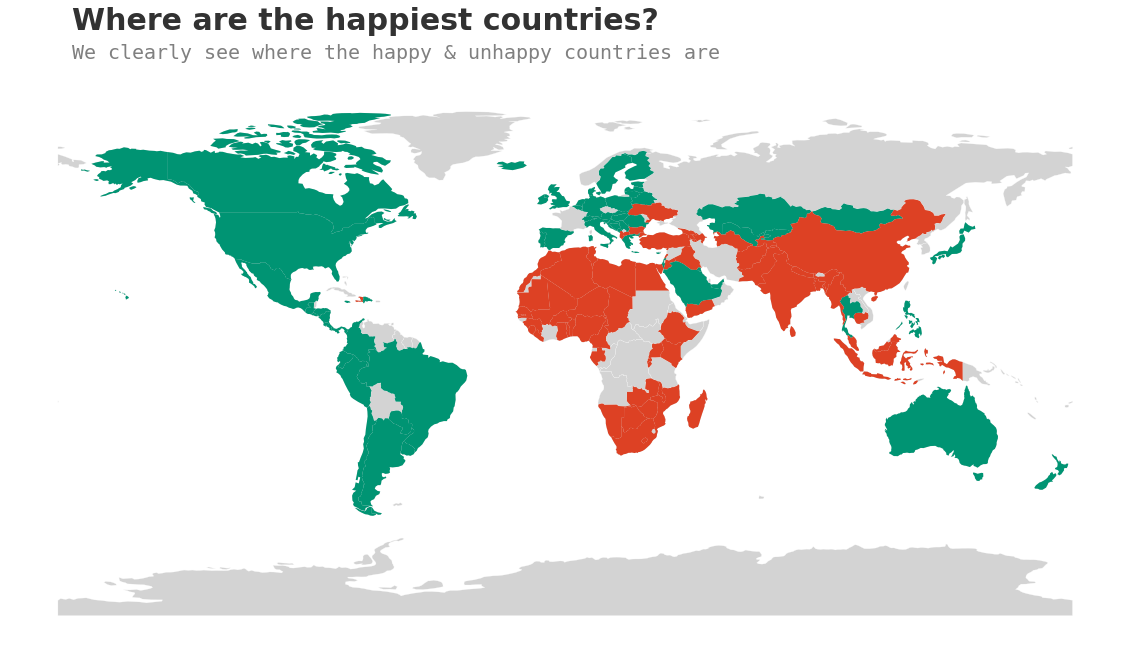

In [17]:
import geopandas
import matplotlib.colors
import pycountry 

#data prep

geo_temp = df



#source: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
geo_temp['CODE']=alpha3code(geo_temp['Country'])


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge=pd.merge(world,geo_temp,on='CODE')


###

# Custom colour map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [low_c,high_c])

ax = world.plot(figsize=(20,15), linewidth=0.25, edgecolor=background_color, color='lightgray')
ax.axis('off')
ax.set_facecolor(background_color)
merge.plot(column='lower_happy',figsize=(20, 15),legend=False,cmap=cmap,ax=ax)


ax.text(-175,112,'Where are the happiest countries?',fontsize=30,fontweight='bold',fontfamily='sansserif',color='#323232')
ax.text(-175,102,'We clearly see where the happy & unhappy countries are',color='gray',fontfamily='monospace',fontsize=20)

plt.show()

This plot confirms what we discovered above, with South Asia and Africa being in the red.

But it also highlights areas we can investigate. For exmaple, China & India, both in the red, have **populations over 1 billion.** Can we investigate population and happiness levels?

# Population

Let's bring in some more factors - such as population.

Does this imapct happiness levels?

In [18]:
# merge on country
df = pd.merge(df, pop, on='Country')
# removing NA value

df=df[df['Urban Pop %'] != 'N.A.']

# Changing data types, removing % strings etc

df['Urban Pop %'] = df['Urban Pop %'].str.rstrip('%').astype('float') / 100.0
df['World Share'] = df['World Share'].str.rstrip('%').astype('float') / 100.0
df['Yearly Change'] = df['Yearly Change'].str.rstrip('%').astype('float') / 100.0
df['Fert. Rate'] = df['Fert. Rate'].astype('float')
df['Med. Age'] = df['Med. Age'].astype('float')

# Adding in some bins

df['Count'] = 1
df['pop_quantile'] = pd.qcut(df['Population (2020)'], 10, labels=False)
df['density_quantile'] = pd.qcut(df['Density (P/Km²)'], 10, labels=False)

merge_safety = df


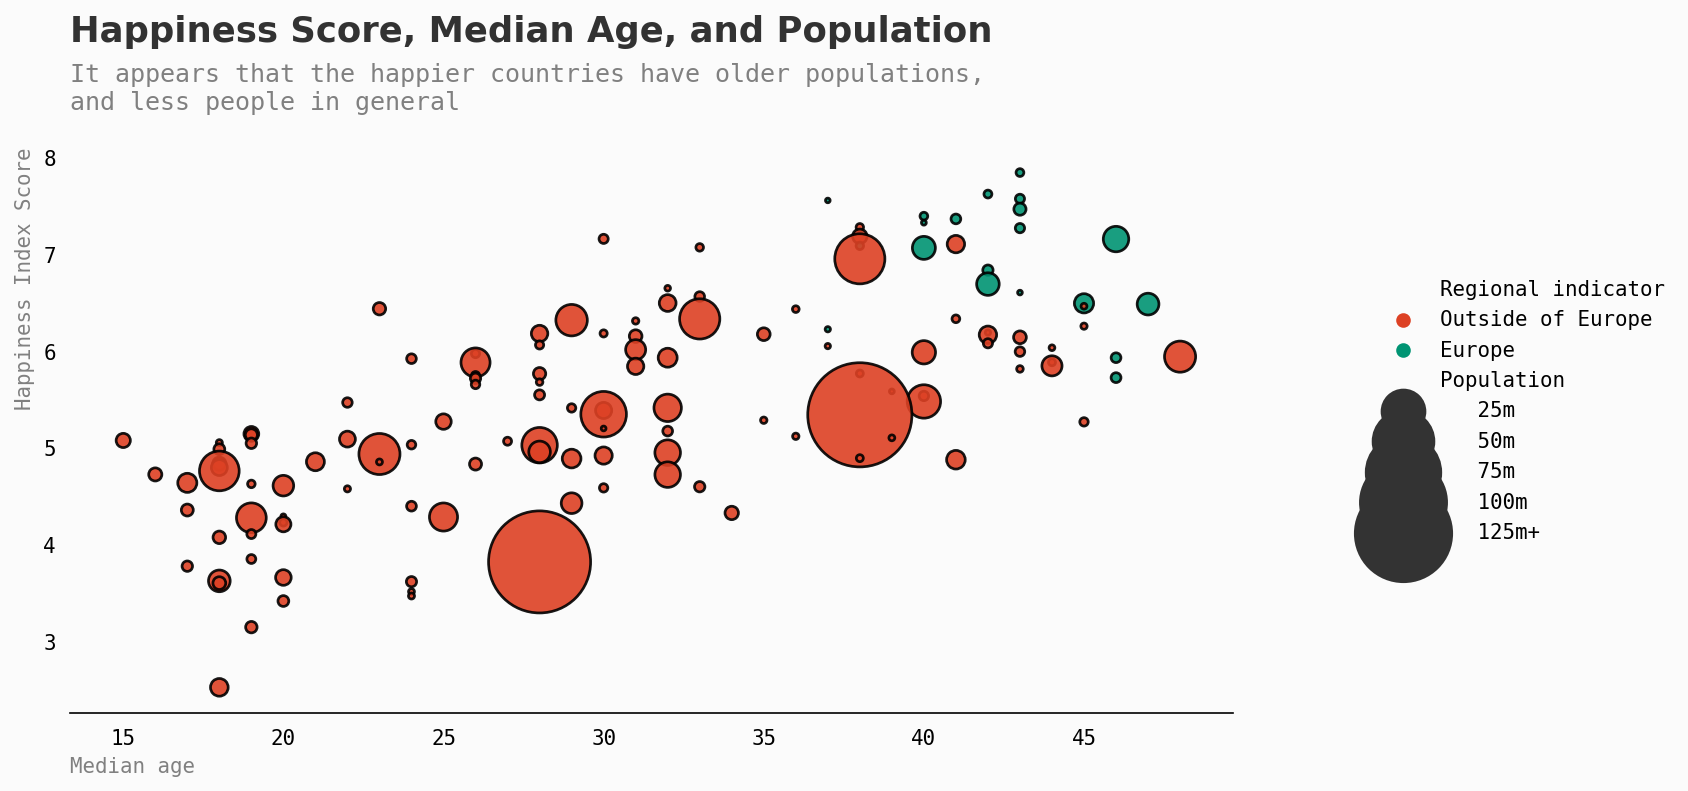

In [19]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Med. Age', y='Ladder score',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',linewidth=1.3,size=df["Population (2020)"]*1000, legend=True, sizes=(5, 2500))

ax.set_xlabel("Median age",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,9.2,'Happiness Score, Median Age, and Population',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(start,8.5,'It appears that the happier countries have older populations,\nand less people in general',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Population')
L.get_texts()[4].set_text('   25m')
L.get_texts()[5].set_text('   50m')
L.get_texts()[6].set_text('   75m')
L.get_texts()[7].set_text('   100m')
L.get_texts()[8].set_text('   125m+')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

We see clearly that happier countries tend to be **older, and less populous**. 

I've included Europe for reference.

What about Fertility rate?

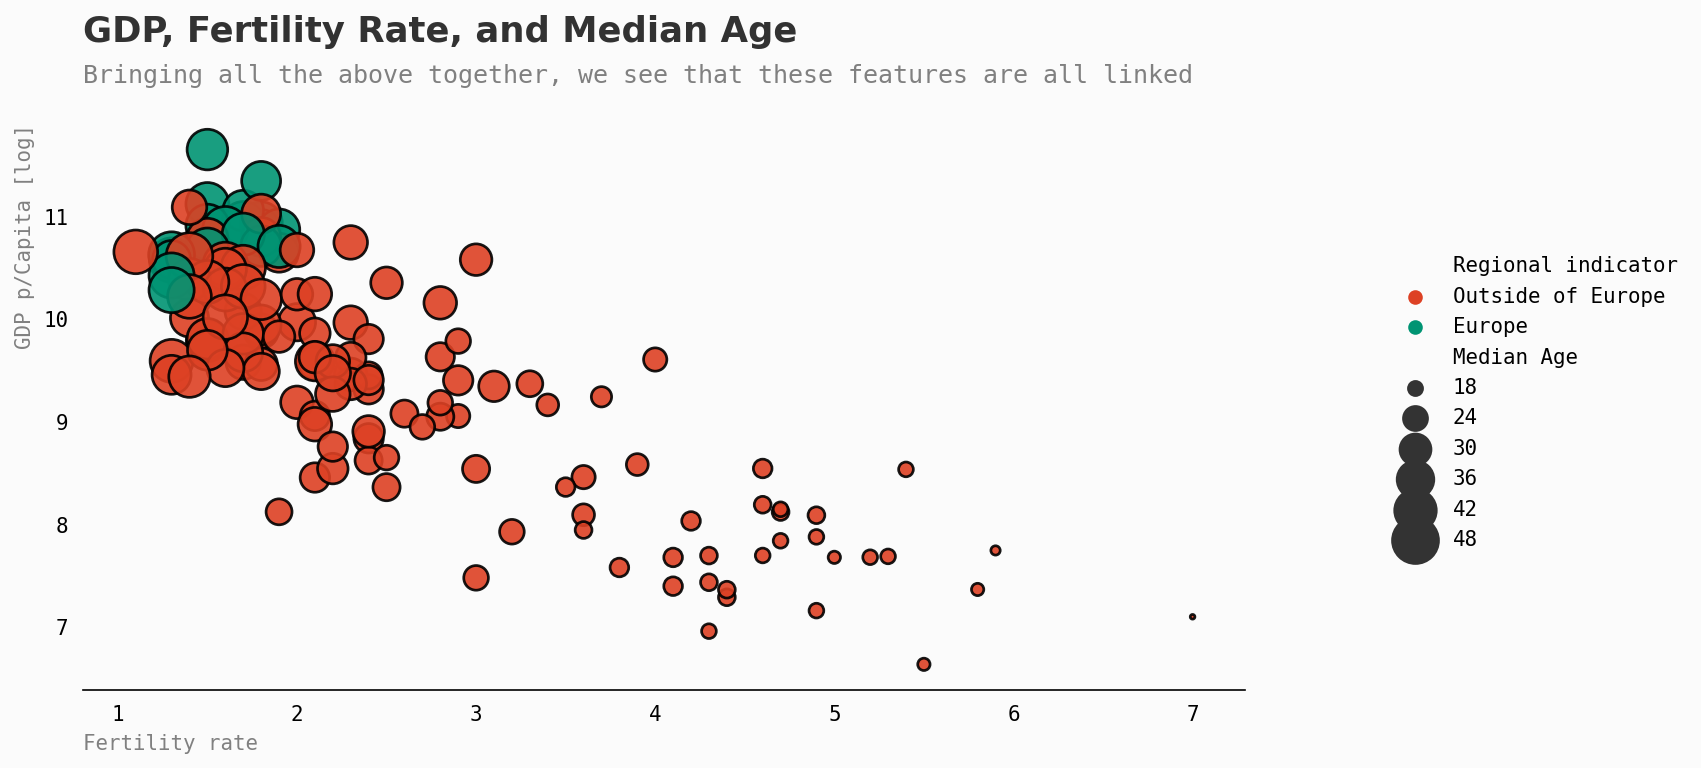

In [20]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

cmap = [low_c,high_c]

ax.set_facecolor(background)
sns.scatterplot(data=df, x='Fert. Rate', y='Logged GDP per capita',hue=df['Regional indicator'] == 'Western Europe',palette=cmap, alpha=0.9,ec='black',linewidth=1.3,size=df["Med. Age"], legend=True, sizes=(5, 500))

ax.set_xlabel("Fertility rate",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("GDP p/Capita [log]",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,12.7,'GDP, Fertility Rate, and Median Age',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(start,12.3,'Bringing all the above together, we see that these features are all linked',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')


L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Outside of Europe')
L.get_texts()[2].set_text('Europe')
L.get_texts()[3].set_text('Median Age')
#L.get_texts()[4].set_text('   25m')


ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

As I suspected, happier countries tend also to have **fewer children**. Likely this is due to access to contraception.

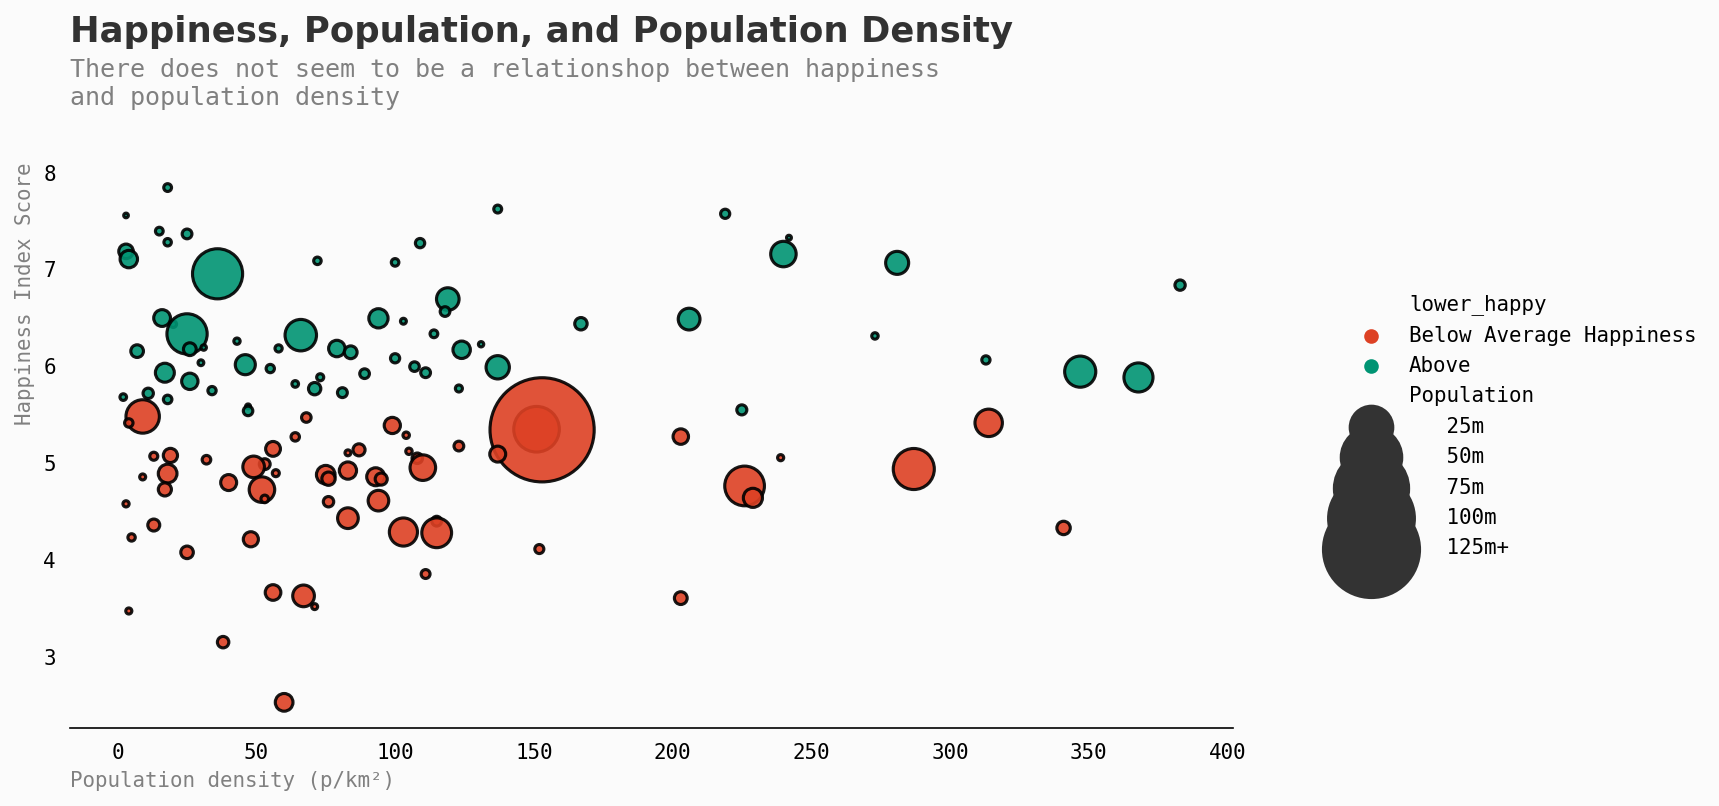

In [21]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

ax.set_facecolor(background)

cmap = [low_c,high_c]

df_plot = df[df['density_quantile'] <9 ]

sns.scatterplot(data=df_plot, x="Density (P/Km²)", y="Ladder score", hue='lower_happy',palette=cmap, size=df_plot["Population (2020)"]*1000, legend=True, sizes=(5, 2500),alpha=0.9,ec='black',linewidth=1.5)

ax.set_xlabel("Population density (p/km²)",fontfamily='monospace',loc='left',color='gray')
ax.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

start, end = ax.get_xlim()
    
ax.text(start,9.35,'Happiness, Population, and Population Density',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(start,8.7,'There does not seem to be a relationshop between happiness\nand population density',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')

L = ax.legend(frameon=False,loc="upper center", bbox_to_anchor=(1.25, 0.8), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
L.get_texts()[1].set_text('Below Average Happiness')
L.get_texts()[2].set_text('Above')
L.get_texts()[3].set_text('Population')
L.get_texts()[4].set_text('   25m')
L.get_texts()[5].set_text('   50m')
L.get_texts()[6].set_text('   75m')
L.get_texts()[7].set_text('   100m')
L.get_texts()[8].set_text('   125m+')

ax.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 

plt.show()

I am surprised that **population density doesn't effect happiness** - though that is due to personal preferences!

# Have there been changes over time?

Do the unhappy get happier?

Is this just a snapshot of a moment in time? Or are the trends more long-standing?

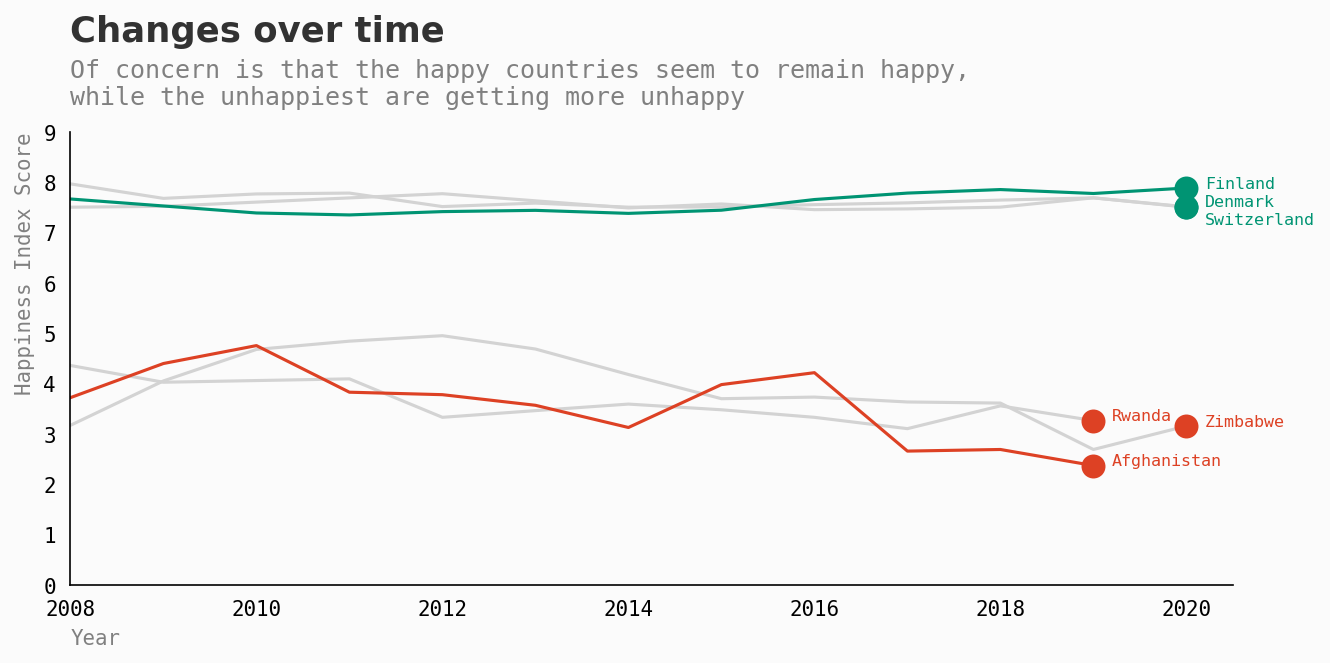

In [22]:
import matplotlib.dates as mdates


fig = plt.figure(figsize=(10, 4), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
    
ax0.set_xlabel("Year",fontfamily='monospace',loc='left',color='gray')
ax0.set_ylabel("Happiness Index Score",fontfamily='monospace',loc='top',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    


ax0.tick_params(axis='both', which='both', left=False, bottom=False,labelbottom=True) 

#low
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Zimbabwe')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Rwanda')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Afghanistan')], x='year', y='Life Ladder',color=low_c)

#high
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Denmark')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Switzerland')], x='year', y='Life Ladder',color='lightgray')
sns.lineplot(ax=ax0,data=df2[(df2['Country']=='Finland')], x='year', y='Life Ladder',color=high_c)


Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()
ax0.plot(2019,df2[(df2['Country']=='Afghanistan')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Zimbabwe')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)
ax0.plot(2019,df2[(df2['Country']=='Rwanda')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=low_c, markeredgewidth=1.5)

ax0.plot(2020,df2[(df2['Country']=='Finland')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c,markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Denmark')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c, markeredgewidth=1.5)
ax0.plot(2020,df2[(df2['Country']=='Switzerland')]['Life Ladder'].reset_index().iloc[-1,-1], 'ko', markersize=10, fillstyle='full',color=high_c, markeredgewidth=1.5)


ax0.text(2020.2,df2[(df2['Country']=='Finland')]['Life Ladder'].reset_index().iloc[-1,-1],'Finland',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Denmark')]['Life Ladder'].reset_index().iloc[-1,-1],'Denmark',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Switzerland')]['Life Ladder'].reset_index().iloc[-1,-1]-0.35,'Switzerland',color=high_c,fontfamily='monospace',fontsize=8, rotation=0)

ax0.text(2019.2,df2[(df2['Country']=='Afghanistan')]['Life Ladder'].reset_index().iloc[-1,-1],'Afghanistan',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2020.2,df2[(df2['Country']=='Zimbabwe')]['Life Ladder'].reset_index().iloc[-1,-1],'Zimbabwe',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)
ax0.text(2019.2,df2[(df2['Country']=='Rwanda')]['Life Ladder'].reset_index().iloc[-1,-1],'Rwanda',color=low_c,fontfamily='monospace',fontsize=8, rotation=0)



ax0.yaxis.set_ticks(np.arange(0, 10, 1))
ax0.set_xlim(left = 2008, right = 2020.5)
plt.xticks(fontname = "monospace")
plt.yticks(fontname = "monospace")

Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.2), 'Changes over time', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax0.text(Xstart, Yend+(Yend*0.06), 
'''
Of concern is that the happy countries seem to remain happy, 
while the unhappiest are getting more unhappy''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')



plt.show()

Of concern here is that the **unhappy stay unhappy, and worse still, they appear to be getting unhappier.**

Is this trend consistent? Or do some countries scores improve over time?

In [23]:
past = df2[['Country','Life Ladder','year']]

pres = df[['Country','Ladder score']]

pres['year'] = 2020

pres.rename(columns={'Ladder score': 'Life Ladder'}, inplace=True)

combined = past.append(pres, ignore_index=False).sort_values(by='year')

seven = combined[combined['year'] == 2007]
seven.rename(columns={'Life Ladder':'07_score'}, inplace=True)
twenty = combined[combined['year'] == 2020]
twenty.rename(columns={'Life Ladder':'20_score'}, inplace=True)

seven = seven.set_index('Country')

twenty = twenty.set_index('Country')

combined = seven.merge(twenty, on='Country', how='inner', suffixes=('_1', '_2'))

combined['change'] = combined['20_score'] - combined['07_score']

top_inc = combined.groupby('Country')['change'].mean().sort_values(ascending=False)[:10]
top_dec = combined.groupby('Country')['change'].mean().sort_values(ascending=True)[:10]

top_changes = top_inc.append(top_dec, ignore_index=False).sort_values(ascending=True)



In [24]:
temp = combined.groupby('Country')['07_score','20_score','change'].mean().sort_values(by='07_score',ascending=False).reset_index()

sample = temp[(temp['Country'] == 'Denmark') | (temp['Country'] == 'United Kingdom') | (temp['Country'] == 'India') | (temp['Country'] == 'Cambodia') 
   | (temp['Country'] == 'North Cyprus') | (temp['Country'] == 'South Africa') | (temp['Country'] == 'Malawi') | (temp['Country'] == 'Niger')
    | (temp['Country'] == 'Australia') | (temp['Country'] == 'Guatemala') | (temp['Country'] == 'Bulgaria') | (temp['Country'] == 'Chile') 
    | (temp['Country'] == 'Jordan') ]

sample = sample.set_index('Country')

In [25]:
top_inc = combined.groupby('Country')['change'].mean().sort_values(ascending=False)[:10]
top_dec = combined.groupby('Country')['change'].mean().sort_values(ascending=True)[:10]

top_changes = top_inc.append(top_dec, ignore_index=False).sort_values(ascending=True)

Let's explore changes over time a little more.

Above, I took a sample of a few countries. Let's plot their changes in a **slopegraph from 2007 to 2020** to see if we can learn anything

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


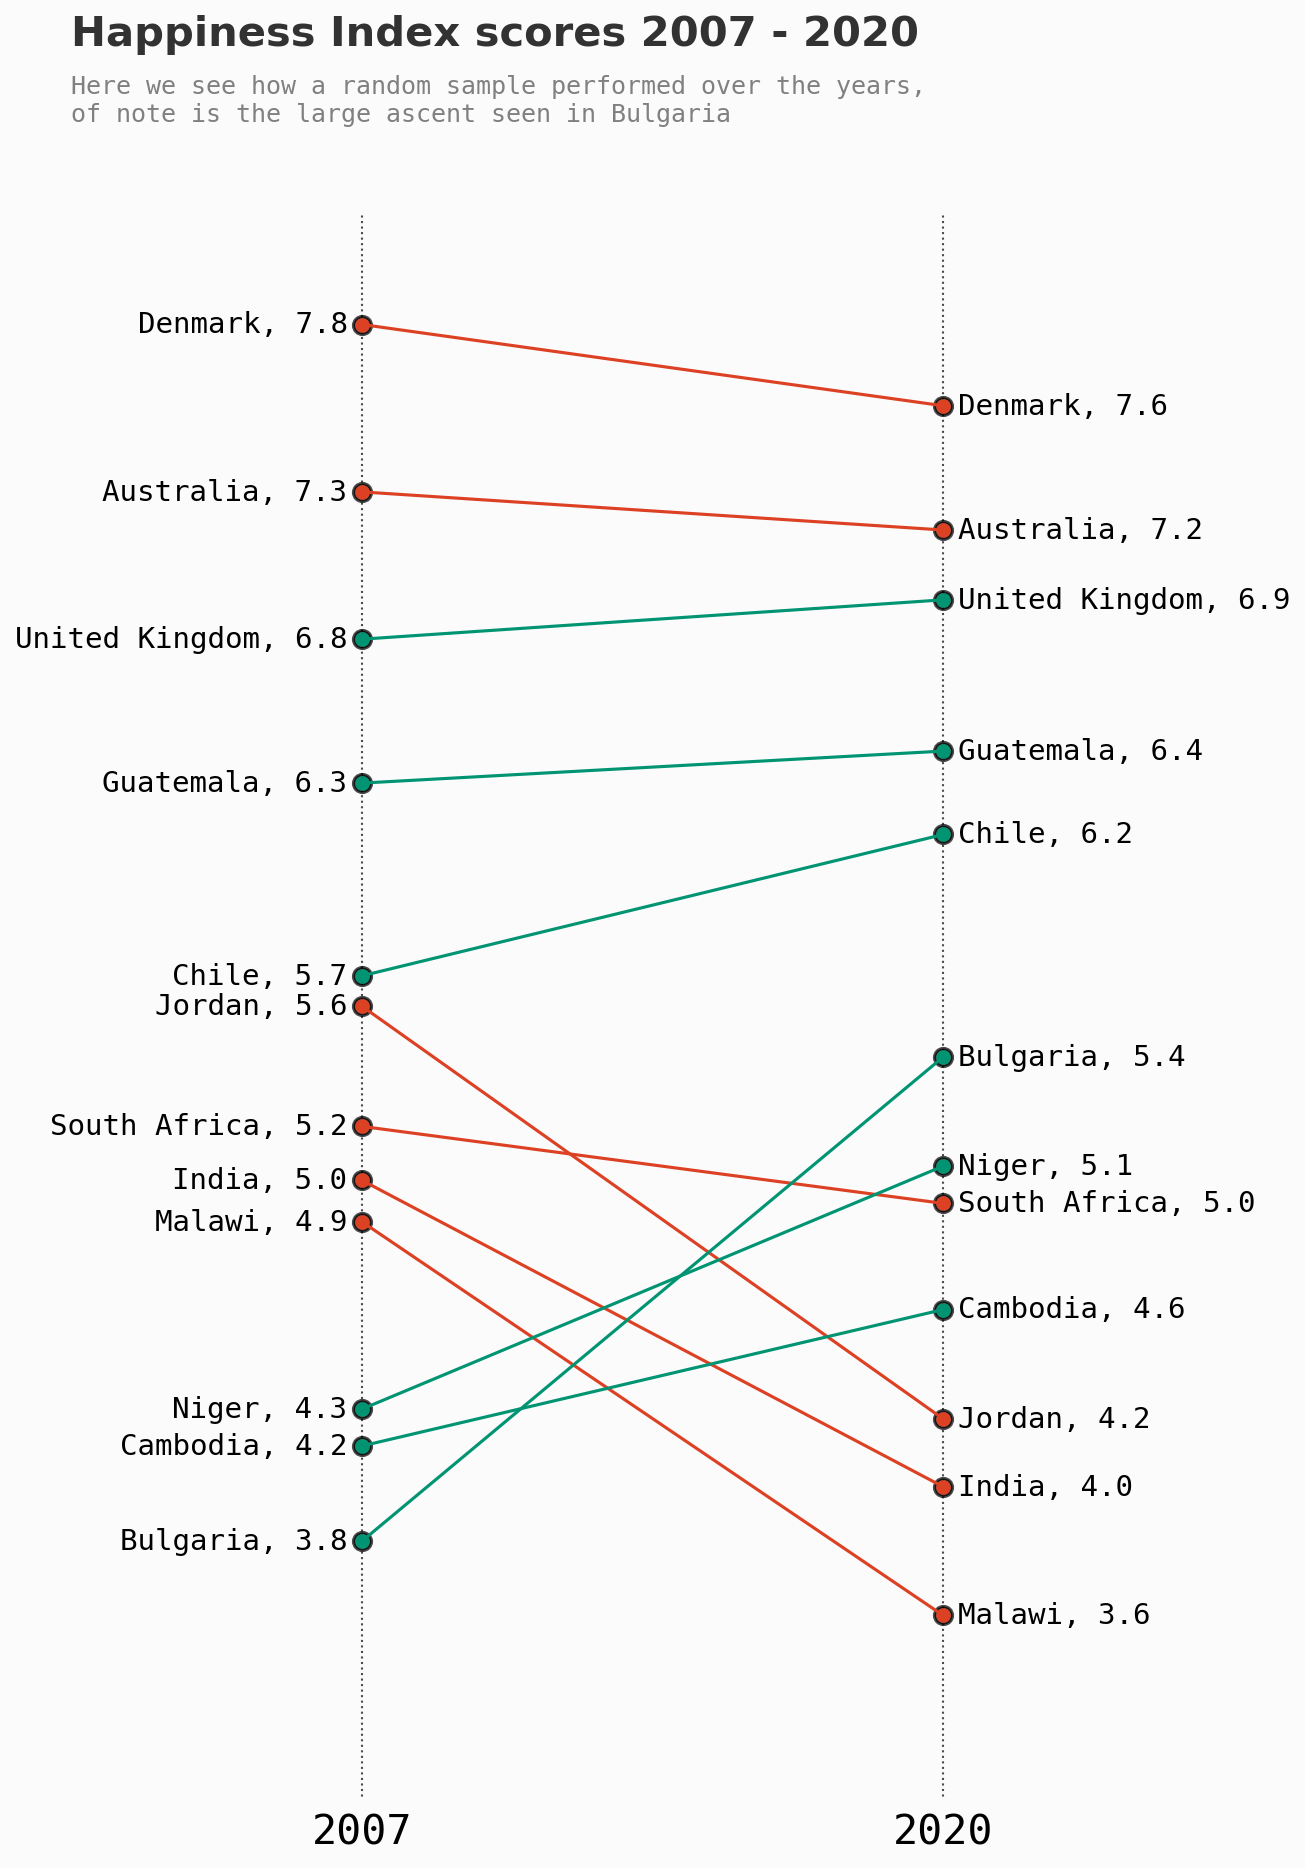

In [26]:
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#18.-Slope-Chart

import matplotlib.lines as mlines

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['07_score'])]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(sample.index, sample['20_score'])]
klass = [low_c if (y1-y2) < 0 else high_c for y1, y2 in zip(sample['07_score'], sample['20_score'])]

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=low_c if p1[1]-p2[1] > 0 else high_c, marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(10,14), dpi= 150, facecolor=background_color)

ax.set_facecolor(background_color)

# Vertical Lines
ax.vlines(x=1, ymin=0, ymax=9, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=0, ymax=9, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=sample['07_score'], x=np.repeat(1, sample.shape[0]), s=75,linewidth=1.5, color='black', alpha=0.7)
ax.scatter(y=sample['20_score'], x=np.repeat(3, sample.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)

# Line Segments and Annotation
for p1, p2, c in zip(sample['07_score'], sample['20_score'], sample.index):
    newline([1,p1], [3,p2])
    ax.text(1-0.05, p1, c + ', ' + str(round(p1,1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.05, p2, c + ', ' + str(round(p2,1)), horizontalalignment='left', verticalalignment='center', fontdict={'size':14})


ax.text(0,8.75,"Happiness Index scores 2007 - 2020", fontsize=20, fontfamily='sansserif',fontweight='bold',color='#323232')
ax.text(0,8.5, 
'''
Here we see how a random sample performed over the years, 
of note is the large ascent seen in Bulgaria''', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')


ax.set(xlim=(0,4), ylim=(3,8.2), ylabel='')
ax.set_xticks([1,3])
ax.set_xticklabels(["2007", "2020"],fontsize=20)
plt.yticks(np.arange(3, 8.2, 2), fontsize=12)

for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)
    
ax.tick_params(axis='both',which='both',left=False,bottom=False,labelleft=False) 
plt.rcParams["font.family"] = "monospace"

plt.show()

Clearly there has indeed been a lot of movement through the years.

Which countries have seen the biggest changes?

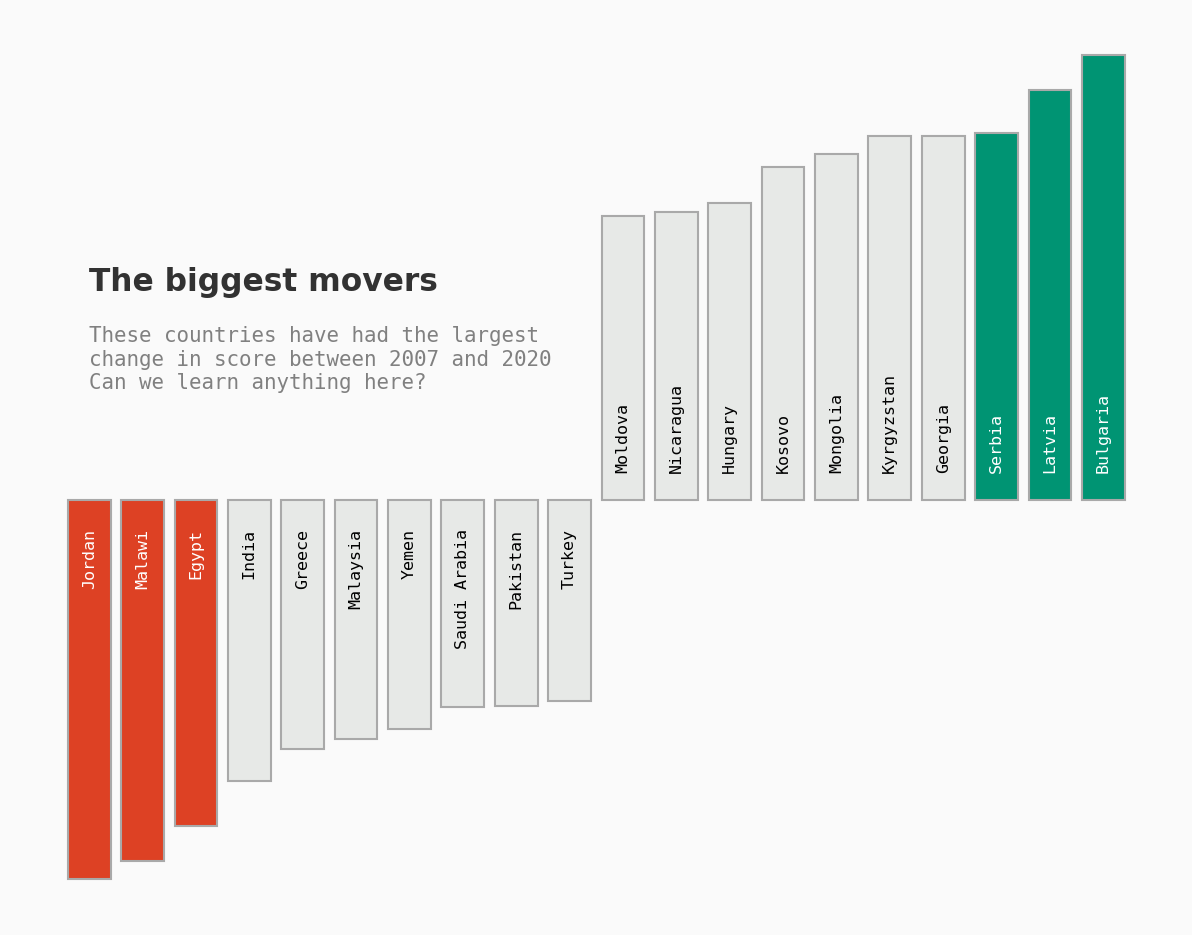

In [27]:
fig = plt.figure(figsize=(10,8),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 


# Plots 
# Happiest
data = top_changes


color_map = ['#e7e9e7' for _ in range(20)]
color_map[0] = color_map[1] = color_map[2] =  low_c # color highlight
color_map[17] = color_map[18] = color_map[19] =  high_c

#base
ax0.bar(data.index, data, 
       edgecolor='darkgray',color='lightgray',alpha=0.1)
# actual
ax0.bar(data.index, data, 
       edgecolor='darkgray',color=color_map)


ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])


for s in ['top','left', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    

for i in range(0,3):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, -0.1), 
                   va = 'top', ha='center',fontweight='light',fontsize=8, color='white',rotation=90)

for i in range(3,10):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, -0.1), 
                   va = 'top', ha='center',fontweight='light',fontsize=8, color='black',rotation=90)

    #top
for i in range(17,20):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, 0.1), 
                   va = 'bottom', ha='center',fontweight='light',fontsize=8, color='white',rotation=90)

for i in range(10,17):
    ax0.annotate(list(data.index)[i], 
                   xy=(i, 0.1), 
                   va = 'bottom', ha='center',fontweight='light',fontsize=8, color='black',rotation=90)

ax0.text(0,0.75,'The biggest movers',fontfamily='sans-serif',fontsize=15,fontweight='bold',color='#323232')
ax0.text(0,0.4,'These countries have had the largest\nchange in score between 2007 and 2020\nCan we learn anything here?',fontfamily='monospace',fontsize=10,fontweight='light',color='gray')

plt.show()

In [28]:
# only top movers
top_ch_list = list(top_changes.reset_index()['Country'])

pre_post = seven.merge(twenty, on='Country', how='inner', suffixes=('_1', '_2')).reset_index()

pre_post = pre_post[pre_post['Country'].isin(top_ch_list)]
pre_post = pre_post.drop_duplicates(subset=['Country'], keep='first')

In [29]:
pre_post['change'] = pre_post['20_score'] - pre_post['07_score']
pre_post.sort_values(by='change')
pre_post = pre_post.set_index('Country')

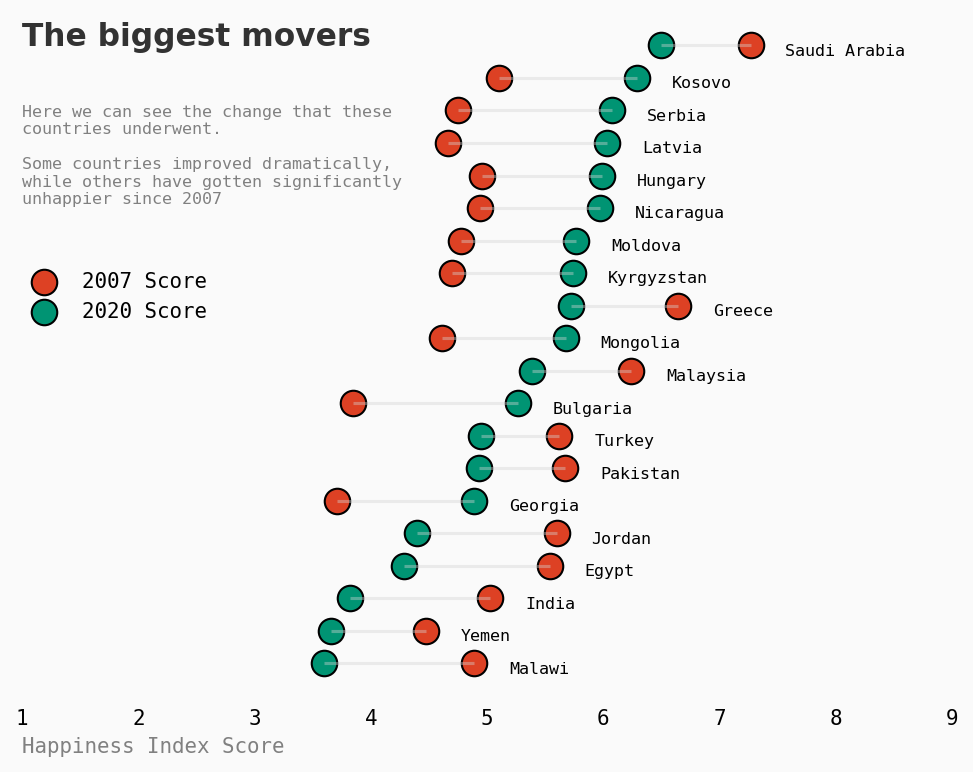

In [30]:
fig = plt.figure(figsize=(8,6),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


value1= pre_post['07_score']
value2=pre_post['20_score']


# Reorder it following the values of the first value:
ordered_df = pre_post.sort_values(by='20_score')
my_range=range(1,len(ordered_df.index)+1)
 

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['07_score'], xmax=ordered_df['20_score'], color='lightgray', alpha=0.4)
plt.scatter(ordered_df['07_score'], my_range, color=low_c, alpha=1, ec='black',label='2007 Score',s=150)
plt.scatter(ordered_df['20_score'], my_range, color=high_c, alpha=1 , ec='black', label='2020 Score',s=150)

ax0.set_yticklabels([])
#plt.locator_params(nbins=10)

for i in range(20):
    ax0.annotate(list(ordered_df.index)[i], 
                   xy=((ordered_df[["07_score", "20_score"]].max(axis=1)[i]+0.3),i+0.6), 
                   va = 'bottom', ha='left',fontweight='light', fontfamily='monospace',fontsize=8, color='black',rotation=0)



Xstart, Xend = ax0.get_xlim()
ax0.xaxis.set_ticks(np.arange(1, 10, 1))

#ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticks([])

# Remove border from plot

for s in ['top','left', 'bottom', 'right']:
    ax0.spines[s].set_visible(False)
    
ax0.set_xlabel("Happiness Index Score",fontfamily='monospace',loc='left',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    
ax0.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 


L = ax0.legend(frameon=False,loc="upper center", bbox_to_anchor=(0.1, 0.65), ncol= 1)
plt.setp(L.texts, family='monospace')
L.get_frame().set_facecolor('none')
#L.get_texts()[1].set_text('Outside of Europe')
#L.get_texts()[2].set_text('Europe')

ax0.text(1,20,'The biggest movers',fontfamily='sans-serif',fontsize=15,fontweight='bold',color='#323232')
ax0.text(1,14.6,
'''
Here we can see the change that these
countries underwent.

Some countries improved dramatically, 
while others have gotten significantly
unhappier since 2007
''',fontfamily='monospace',fontsize=8,fontweight='light',color='gray')

plt.show()

Let's compare the biggest gainer & the biggest loser in terms of the happiness index scores: Bulgaria & Jordan.

We'll compare how they both got on over the years

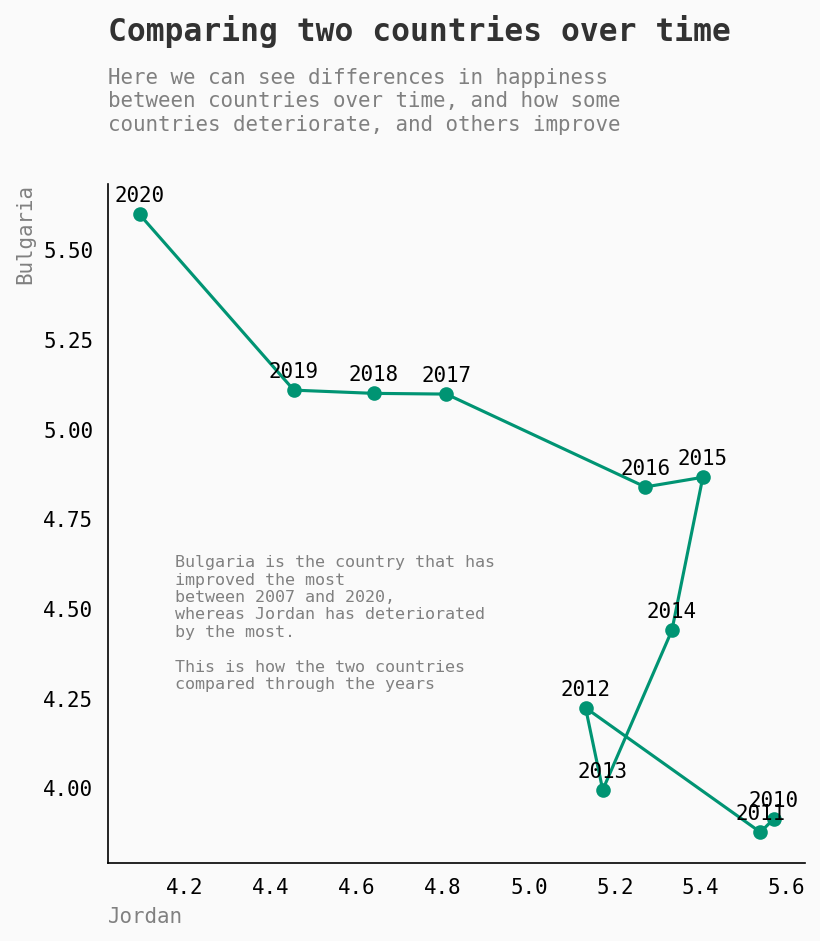

In [31]:
fig = plt.figure(figsize=(6,6),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

c1 = 'Jordan'
c2 = 'Bulgaria'

# filter data
df = df2.loc[(df2['Country']==c1) | (df2['Country']==c2)]
df = df2.loc[(df2['year']>2008)]
df = pd.pivot_table(df, values='Life Ladder', index=['year'], columns=['Country'])


# plot the connected scatterplot
plt.plot(df[c1], df[c2], '-', marker='o',color=high_c)

# add annotations in every 3 data points with a loop
for line in range(0, df.shape[0], 1):
     plt.annotate(
          df.index[line], 
          (df[c1].iloc[line], df[c2].iloc[line]+0.025) ,
          va='bottom',
          ha='center',fontfamily='monospace'
     )
        

for s in ['top','right']:
    ax0.spines[s].set_visible(False)
    
#ax0.xaxis.set_ticks(np.arange(1, 10, 1))
ax0.set_ylabel(f"{c2}",fontfamily='monospace',loc='top',color='gray')
ax0.set_xlabel(f"{c1}",fontfamily='monospace',loc='left',color='gray')
ax0.tick_params(axis = 'both', which = 'major', labelsize = 10)
    

ax0.tick_params(axis='both', which='both',left=False, bottom=False,labelbottom=True) 


Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart,Yend+0.4,'Comparing two countries over time',fontsize=15,fontweight='bold',color='#323232')
ax0.text(Xstart,Yend+0.15,'Here we can see differences in happiness\nbetween countries over time, and how some\ncountries deteriorate, and others improve',fontsize=10,fontfamily='monospace',color='gray')

fig.text(0.2,0.3,
'''
Bulgaria is the country that has
improved the most 
between 2007 and 2020, 
whereas Jordan has deteriorated 
by the most. 

This is how the two countries
compared through the years
''',fontfamily='monospace',fontsize=8,color='gray')

# x axis label
plt.xlabel(c1)

# y axis label
plt.ylabel(c2)

# show the graph
plt.show()

Whilst I explore this idea of temporal change, I want to look at a continental perspective.

For example, are all countries in Western Europe 'happy'?

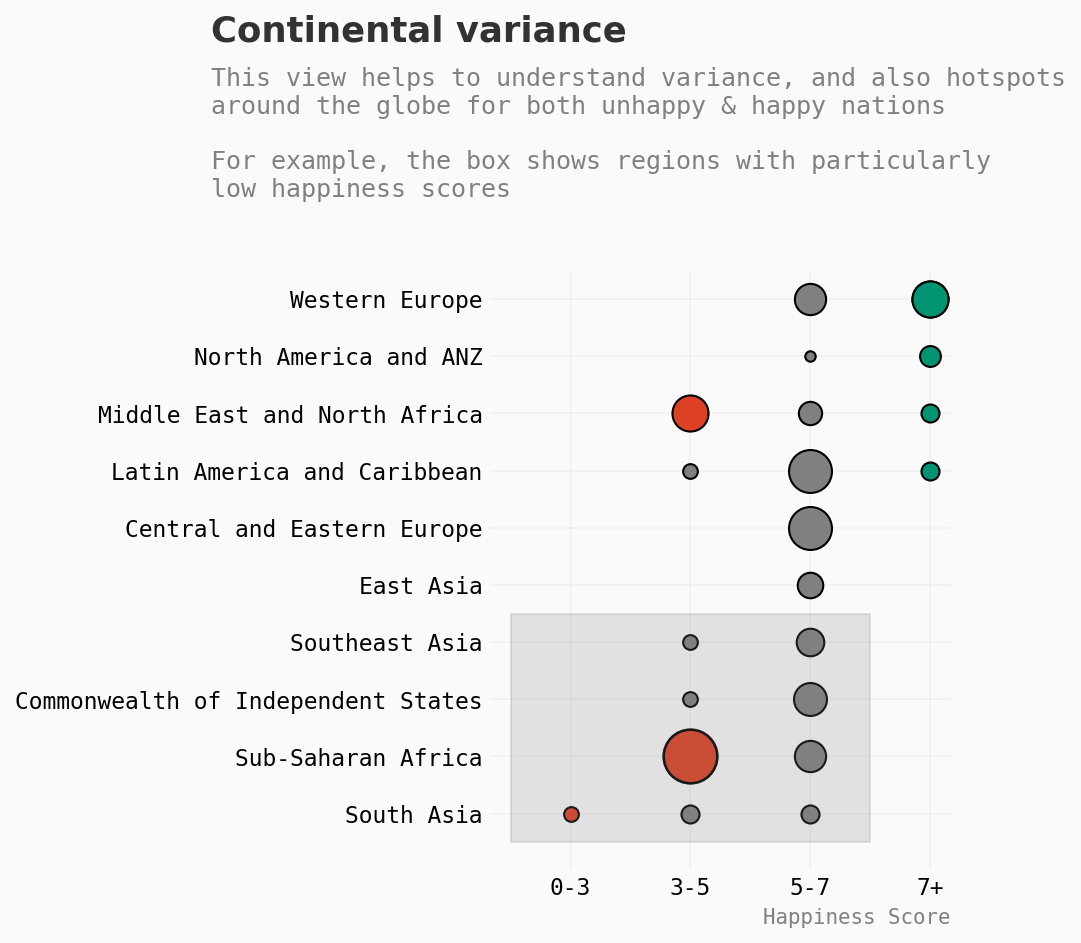

In [32]:
safety['bin'] = safety['Ladder score'].apply(lambda x: '0-3' if x <= 3 else '3-5' if x <= 5 else '5-7' if x <= 7 else '7+')

bin_order = ['0-3','3-5','5-7','7+']

cont_order = ['Western Europe', 'North America and ANZ',
       'Middle East and North Africa', 'Latin America and Caribbean',
       'Central and Eastern Europe', 'East Asia', 'Southeast Asia',
       'Commonwealth of Independent States', 'Sub-Saharan Africa',
       'South Asia']

safety['count'] = 1

# matrix plot

data_matrix = pd.pivot_table(safety, values='count', index=['Regional indicator'], columns=['bin'], aggfunc=np.sum).fillna(0).astype(int).loc[cont_order, bin_order].stack()

plt.rcParams["font.family"] = "monospace"

fig = plt.figure(figsize=(5, 9), dpi=150)
gs = fig.add_gridspec(5, 5)
ax0 = fig.add_subplot(gs[1:4, 0:4]) 
background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

for item in cont_order[::-1]:
    for item_2 in bin_order:
        size = data_matrix[item][item_2]
        ax0.scatter(item_2, item, s=size*25, color='gray',ec='black',linewidth=1) 

#highlights
ax0.scatter(1, 1, s=650, color='#dd4124',ec='black',linewidth=1,alpha=1)    
ax0.scatter(0, 0, s=50, color='#dd4124',ec='black',linewidth=1,alpha=1) 
ax0.scatter(1, 7, s=300, color='#dd4124',ec='black',linewidth=1,alpha=1) 

ax0.scatter(3, 9, s=300, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 8, s=100, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 7, s=75, color='#009473',ec='black',linewidth=1,alpha=1) 
ax0.scatter(3, 6, s=75, color='#009473',ec='black',linewidth=1,alpha=1) 

ax0.grid(linewidth=0.1)        
ax0.set_xticklabels(bin_order, fontsize=11, rotation=0)
plt.yticks(fontsize=11)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
ax0.text(-3,13.5,'Continental variance',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax0.text(-3,10.3,
'''
This view helps to understand variance, and also hotspots
around the globe for both unhappy & happy nations

For example, the box shows regions with particularly
low happiness scores
''',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')    

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.set_axisbelow(True)
plt.xlabel('Happiness Score',loc='right',color='gray')


#rect

X, Y = -0.5, -0.5


ax0.add_patch(Rectangle((X, Y), 3, 4,alpha=0.2, edgecolor='gray',facecolor='gray'))
plt.show()

Europe though seems almost exclusively without worry. Is this true? Doubtful.

Let's explore Europe a little more...

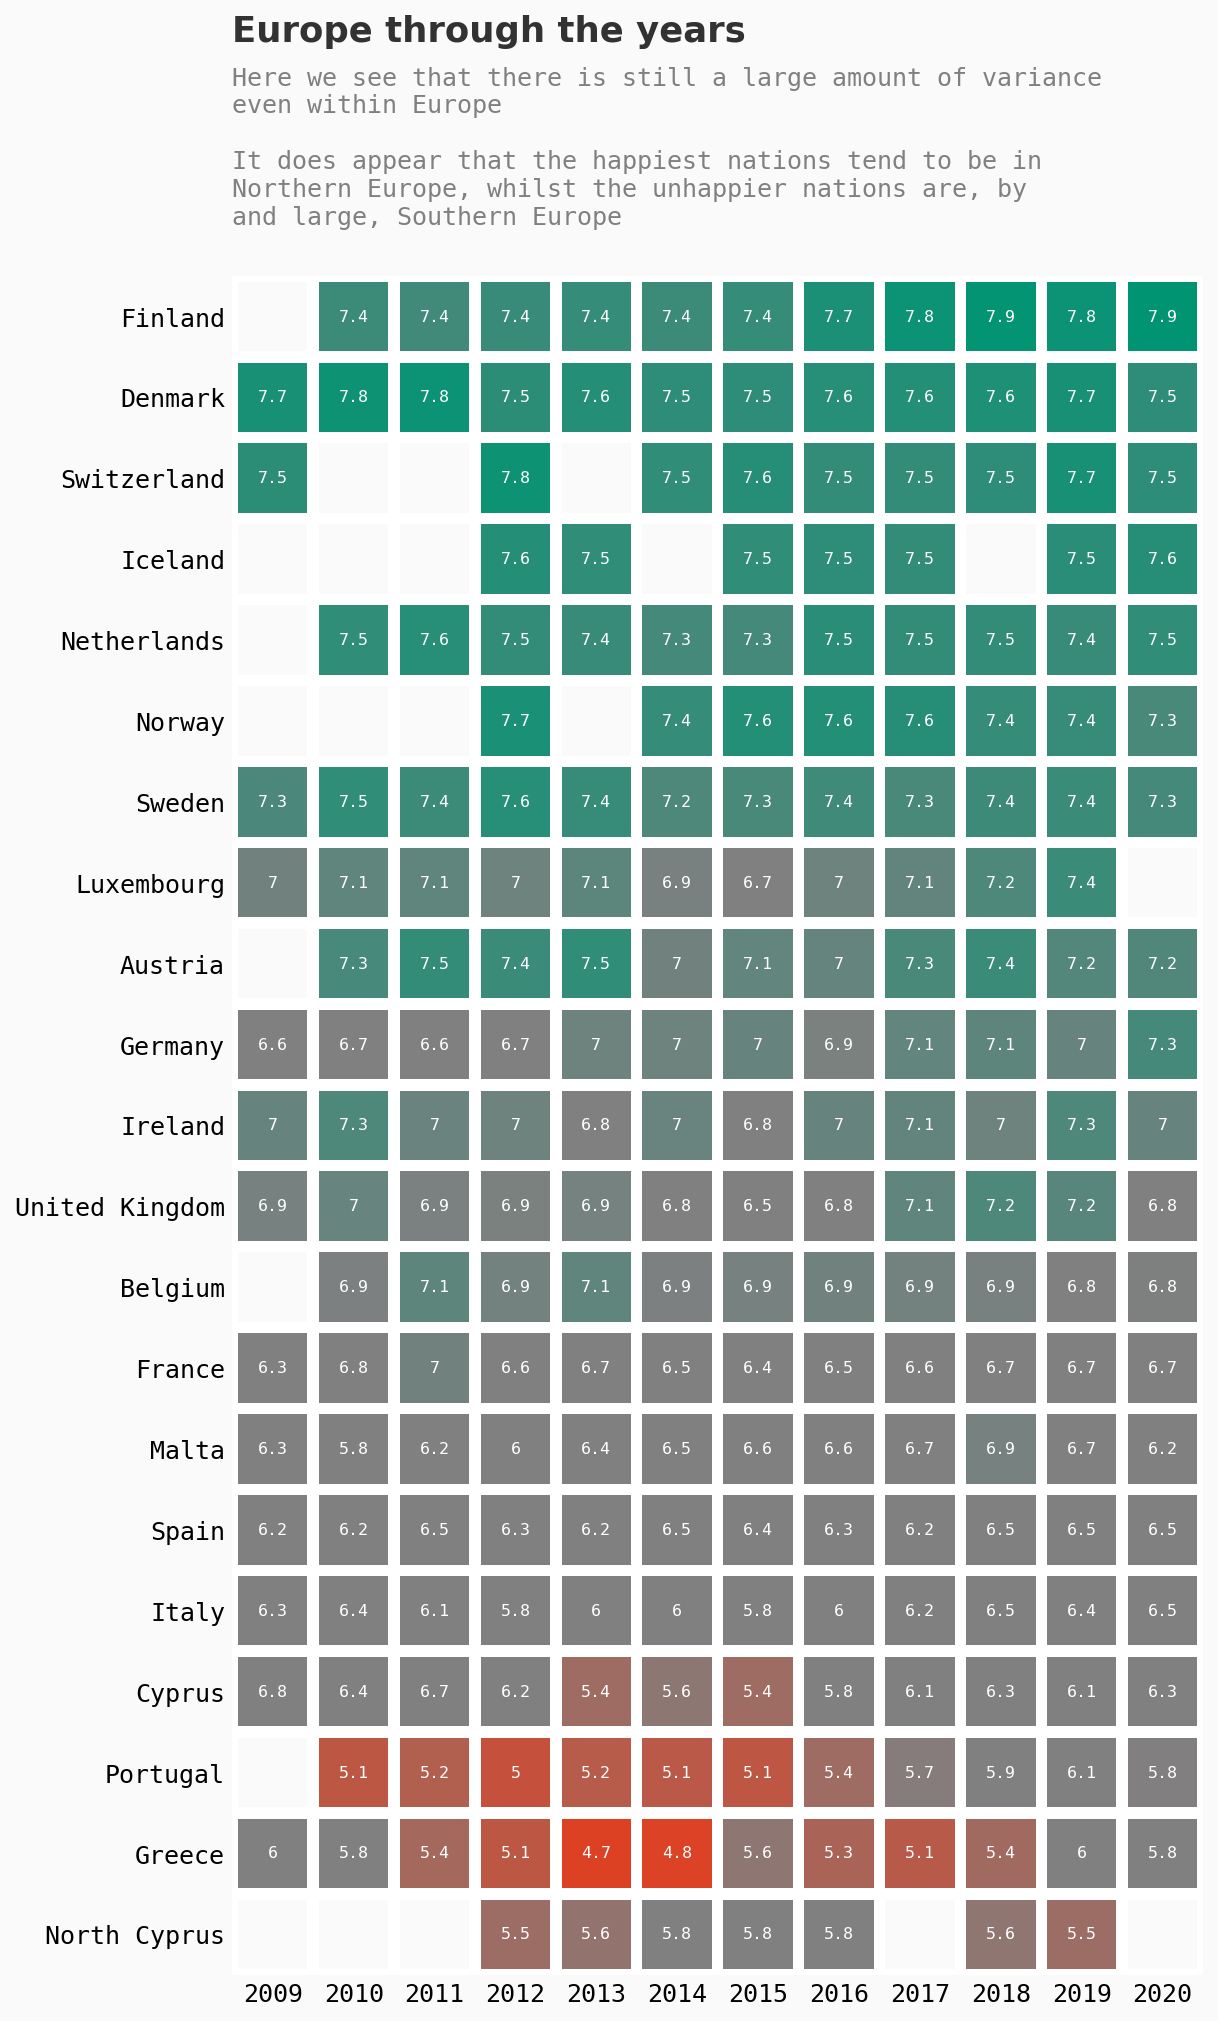

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), dpi=150, facecolor=background_color)
ax.set_facecolor(background_color) 

plt.rcParams["font.family"] = "monospace"


colors = [low_c,'gray','gray',high_c]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(df[list(safety[safety['Regional indicator'] == 'Western Europe']['Country name'])].T, 
            square=True,
            linewidth=5, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True,annot_kws={"size": 8})

ax.spines['top'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(rotation=0,fontfamily='monospace',size=12)
plt.xticks(rotation=0,fontfamily='monospace', size=12)

ax.tick_params(axis=u'both', which=u'both',length=0)

ax.text(0,-2.9,'Europe through the years',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(0,-0.3,
'''
Here we see that there is still a large amount of variance
even within Europe

It does appear that the happiest nations tend to be in
Northern Europe, whilst the unhappier nations are, by 
and large, Southern Europe
''',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')

plt.show()

so within Europe there are indeed countries that might be considered 'unhappy', such as North Cyprus and Greece.

As I noted above, the North-South split is a well known issue within Europe, and even within countries such as Italy.

Let's explore the variance in happiness index scores across all continents now...

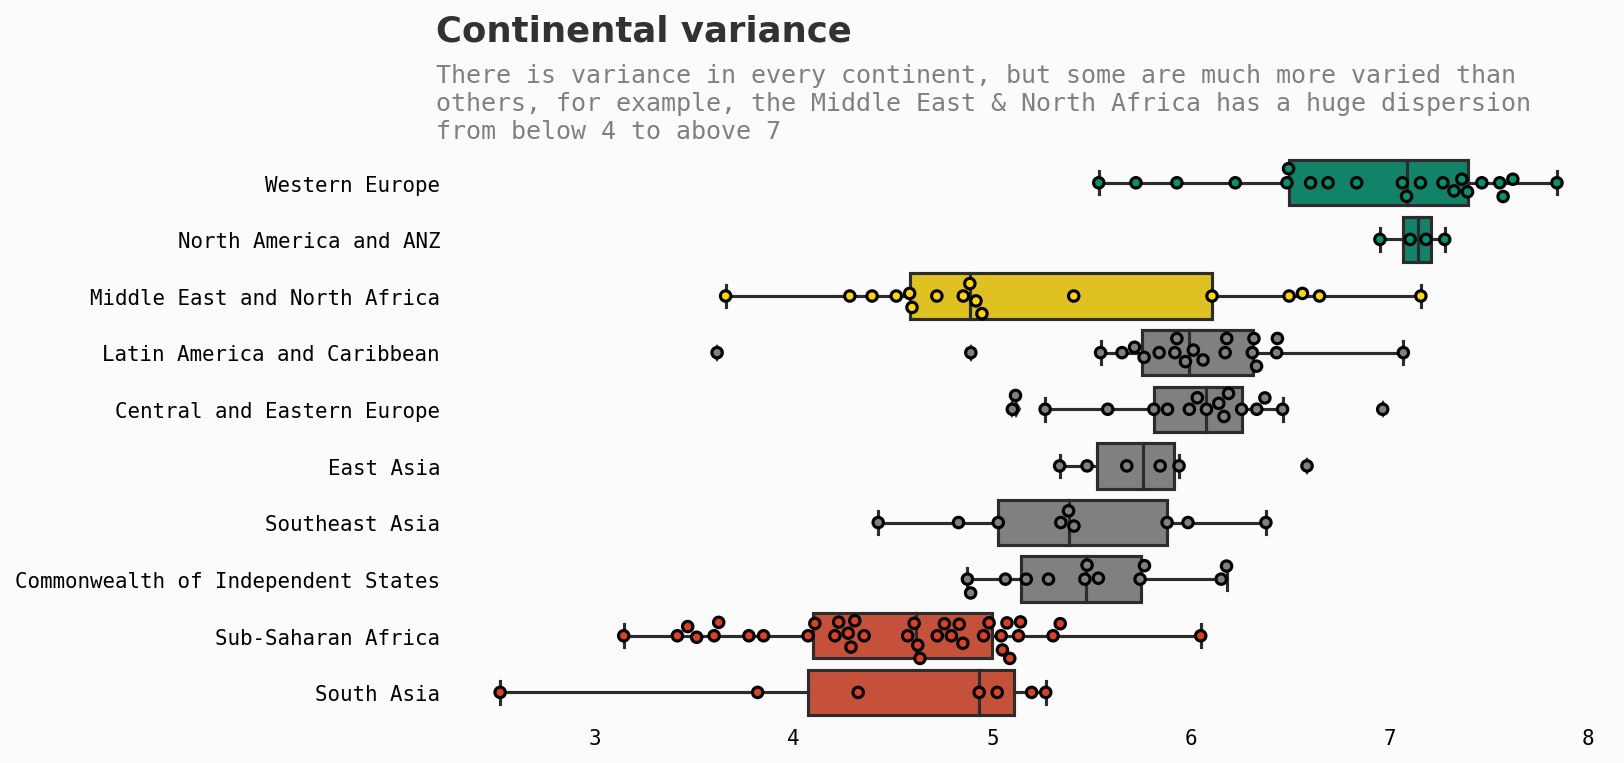

In [34]:
background = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 5),dpi=150)
fig.patch.set_facecolor(background) # figure background color

ax.set_facecolor(background)

pal = {'Western Europe':high_c, 
'North America and ANZ':high_c,
'Middle East and North Africa':'gold',
'Latin America and Caribbean':'gray',
'Central and Eastern Europe':'gray',
'East Asia':'gray',
'Southeast Asia':'gray',
'Commonwealth of Independent States':'gray',
'Sub-Saharan Africa':low_c,
'South Asia':low_c}


ax = sns.boxplot(y='Regional indicator', x='Ladder score', data=safety,palette=pal)


 
# Add jitter with the swarmplot function
ax = sns.swarmplot(y='Regional indicator', x='Ladder score', data=safety, ec='black',linewidth=1.5,palette=pal)

for s in ['top','left','bottom','right']:
    ax.spines[s].set_visible(False)
    
ax.text(2.2,-2.5,'Continental variance',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(2.2,-0.3,
'''
There is variance in every continent, but some are much more varied than 
others, for example, the Middle East & North Africa has a huge dispersion
from below 4 to above 7
''',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')
    
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

As I suspected, there is of course variance within every continent/region.

However, highlighted above is the Middle East & North Africa because it has such a large spread in happiness scores.

Let's repeat the plot from earlier on to see how each country in that region has scored over the years...

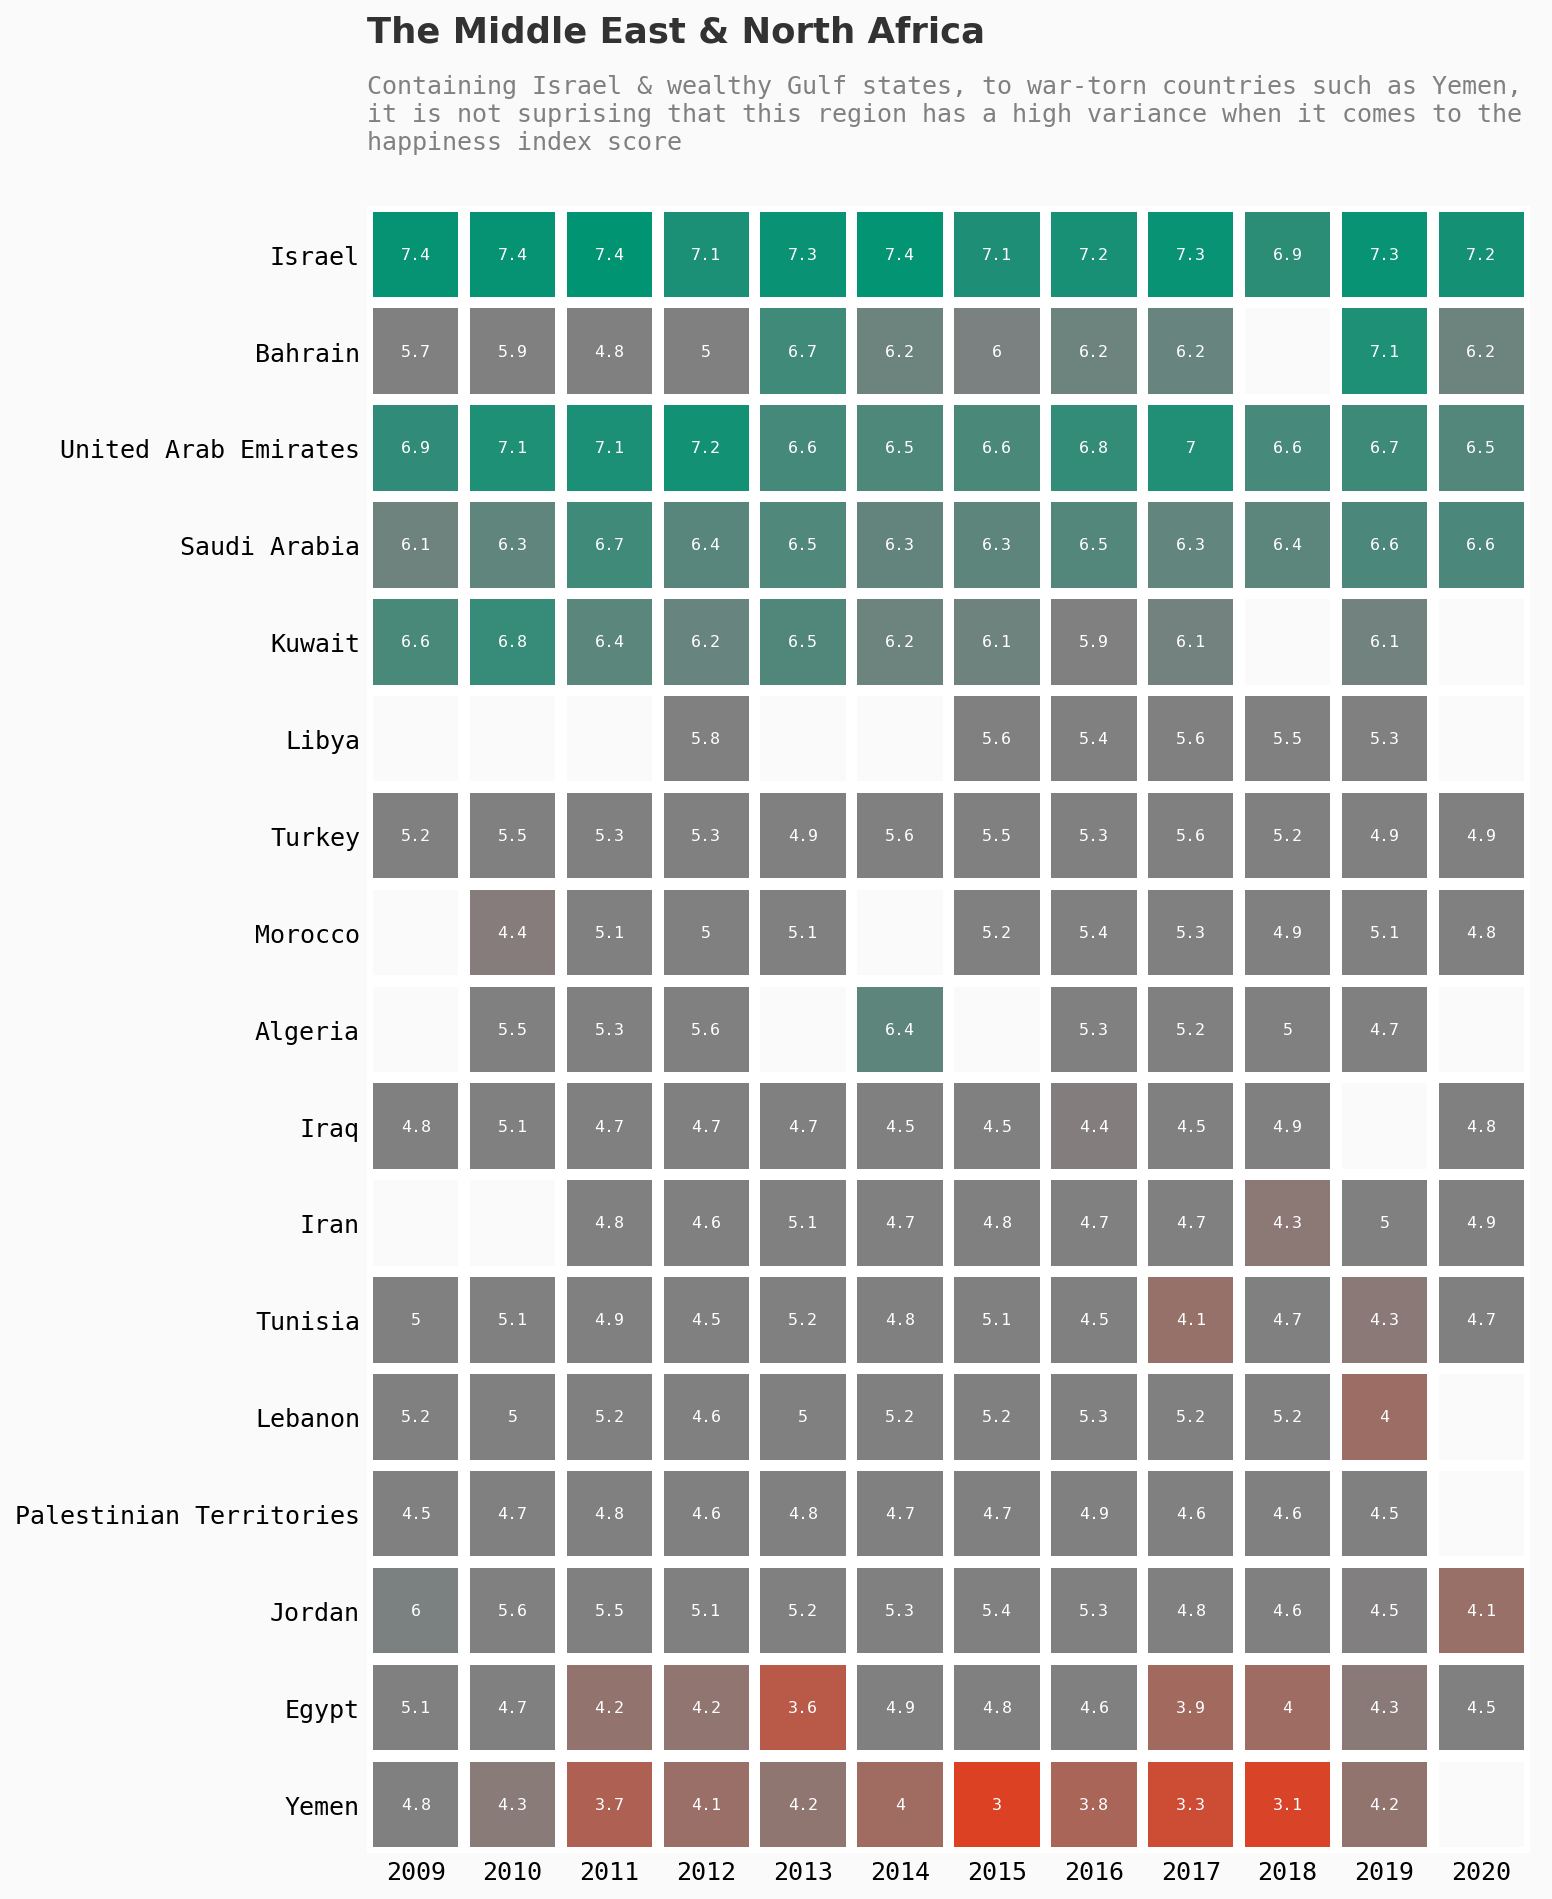

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15), dpi=150, facecolor=background_color)
ax.set_facecolor(background_color) 

plt.rcParams["font.family"] = "monospace"


colors = [low_c,'gray','gray',high_c]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(df[list(safety[safety['Regional indicator'] == 'Middle East and North Africa']['Country name'])].T, 
            square=True,
            linewidth=5, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True,annot_kws={"size": 8})

ax.spines['top'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
plt.yticks(rotation=0,fontfamily='monospace',size=12)
plt.xticks(rotation=0,fontfamily='monospace', size=12)

ax.tick_params(axis=u'both', which=u'both',length=0)

ax.text(0,-1.7,'The Middle East & North Africa',fontfamily='sansserif',fontweight='normal',fontsize=17,weight='bold',color='#323232')
ax.text(0,-0.3,
'''
Containing Israel & wealthy Gulf states, to war-torn countries such as Yemen, 
it is not suprising that this region has a high variance when it comes to the
happiness index score
''',fontfamily='monospace',fontweight='light',fontsize=12,color='gray')

plt.show()

This region contains many countries that are in vastly different political realities - from war to peace, which of course will have a large effect on happiness scores.

Despite the intercontinental variance, it is actually the case that there are only a few countries to have ever topped the leaderboard. 

It does not seem like this will be changing any time soon either.


findfont: Font family ['sanserif'] not found. Falling back to DejaVu Sans.


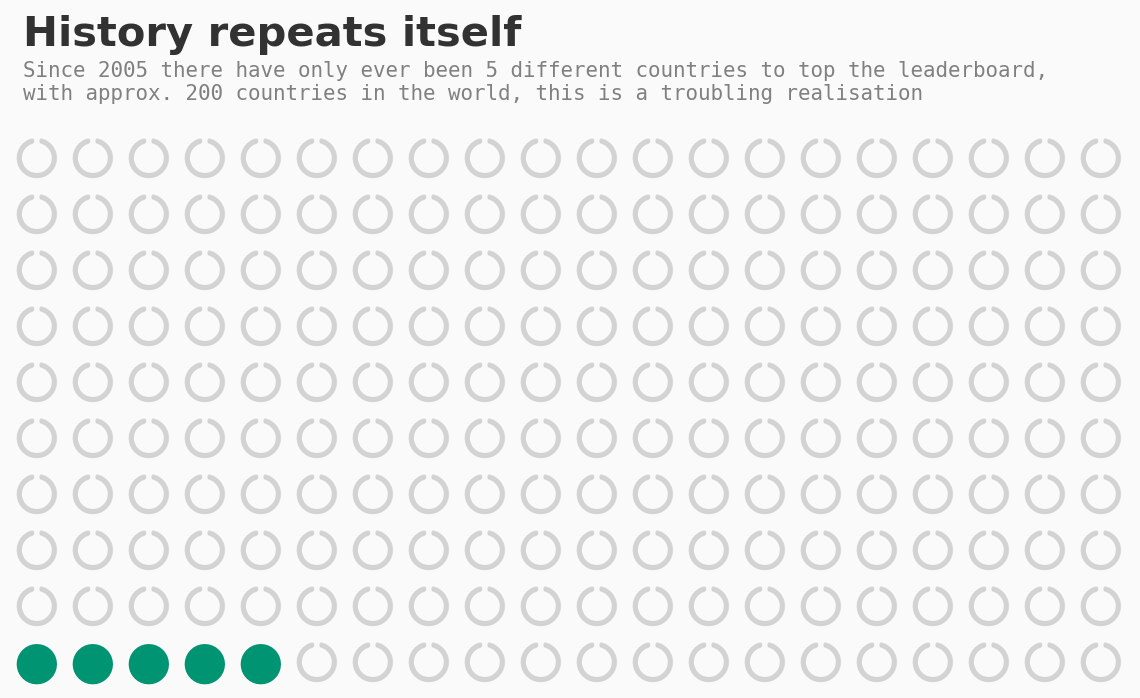

In [36]:
from pywaffle import Waffle
fig = plt.figure(figsize=(12, 4),dpi=150,facecolor=background_color,
    FigureClass=Waffle,
    rows=10,
    values=[5, 195],
    colors=[high_c, "lightgray"],
    icons=['circle','circle-notch'],
    font_size=20,vertical=True,
)

fig.text(0.017,1.1,'History repeats itself',fontfamily='sanserif',fontsize=20,fontweight='bold',color='#323232')
fig.text(0.017,1.01,'Since 2005 there have only ever been 5 different countries to top the leaderboard,\nwith approx. 200 countries in the world, this is a troubling realisation',fontfamily='monospace',color='gray',fontsize=10)
plt.show()

# Last steps: Clustering

Now we have a clear understanding of our data.

Earlier, I mentioned that there appeared to be **three clusters** in our dataset between regions. 

Let's formally cluster our data and see if the intuitions, **uncovered purely by exploratory data analysis**, prove correct.

In [37]:

refined_merge = merge_safety[['Country','Ladder score',
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)',
       'Migrants (net)', 'Fert. Rate', 'Med. Age', 'Urban Pop %']]

# Decided not to use this plot - heatmap agaisnt one variable, in this case, ladder score

#fig, ax = plt.subplots(figsize=(1,8), dpi=150)
#fig.patch.set_facecolor(background) # figure background color
#ax.set_facecolor(background)

#colors = [low_c,'gray','gray',high_c]
#sns.heatmap(refined_merge.corr()[['Ladder score']].sort_values('Ladder score'),
# vmax=1, vmin=-1, cmap=colors, annot=True,cbar=False,linewidth=5, ax=ax);
#ax.invert_yaxis()
#ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.show()

I'll use **K-Means** and  **the Elbow Method** to select the number of clusters.

In the Elbow method, we are actually varying the number of clusters (K) from 1 – 6 in this caase. 

For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. From this point, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

A good read and source for above description:
(https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/)

findfont: Font family ['sansserif'] not found. Falling back to DejaVu Sans.


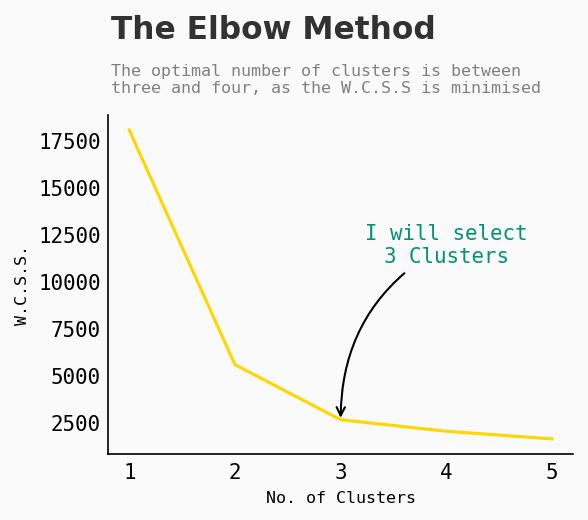

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X = refined_merge[['Ladder score','Logged GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Fert. Rate', 'Med. Age',
       'Urban Pop %']]



wcss = []
for i in range(1, 6):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 20, n_init = 10, random_state = 0)
    km.fit(X)
    wcss.append(km.inertia_)
    
    
###

fig = plt.figure(figsize=(4,3),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])


background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
for s in ['top','right']:
    ax0.spines[s].set_visible(False)
    
fig.text(0.13,0.93,
'''
The optimal number of clusters is between 
three and four, as the W.C.S.S is minimised''',fontsize=8, color='gray',ha='left')

fig.text(0.13,1.05,'The Elbow Method',fontfamily='sansserif',fontweight='bold',fontsize=15,color='#323232')

plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.annotate('I will select\n3 Clusters', xy=(3, 2500), xytext=(4, 11000),
             arrowprops=dict(facecolor='steelblue',arrowstyle="->",connectionstyle="arc3,rad=.3"), fontsize=10,fontfamily='monospace',ha='center', color=high_c)

    
plt.plot(range(1, 6), wcss,color='gold')
plt.xlabel('No. of Clusters',fontsize=8)
plt.ylabel('W.C.S.S.',fontsize=8)
plt.show()



We can now **create 3 clusters** within our dataset.

This can help for further analysis, and aid in **building our understanding even further**

In [39]:
# Create clusters
kmeans = KMeans(n_clusters=3)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")
refined_merge['Cluster'] = X["Cluster"].astype("category")


# Cluster overview

We can now repeat the plot from earlier, but this time, **splitting the data in to our 3 new clusters**

In [40]:
refined_merge.groupby('Cluster')['Ladder score'].mean()

Cluster
0    6.370569
1    4.352895
2    5.547958
Name: Ladder score, dtype: float64

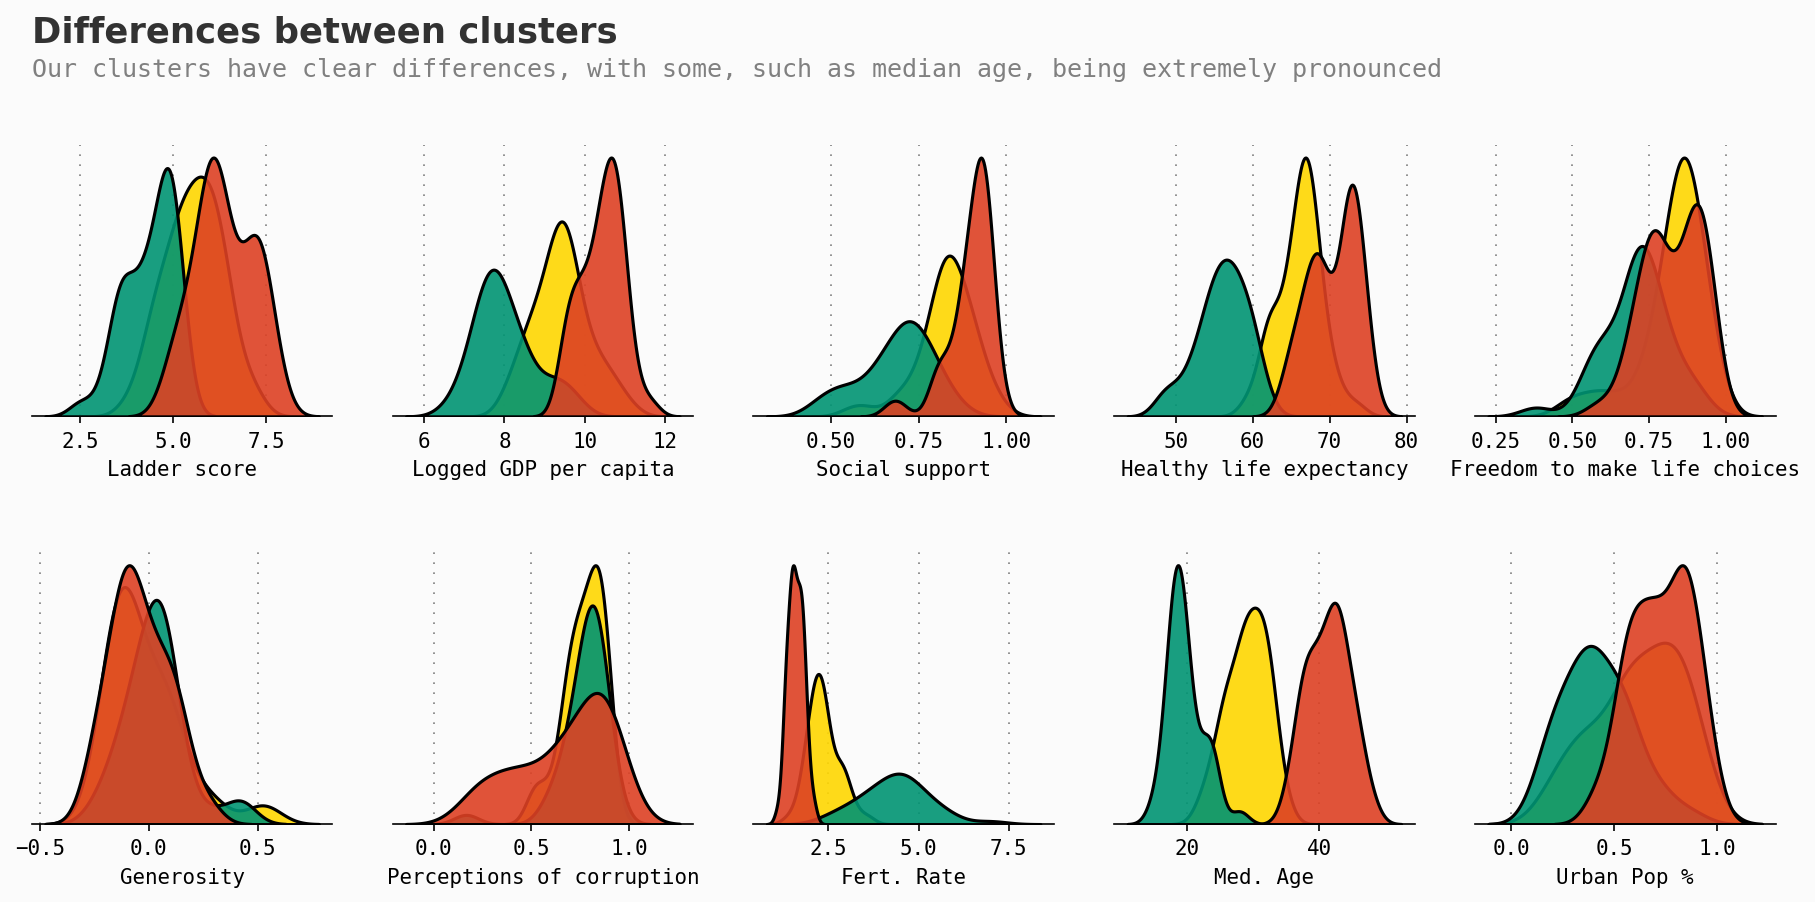

In [41]:
background_color = '#fbfbfb'
fig = plt.figure(figsize=(15, 6), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 5)
gs.update(wspace=0.2, hspace=0.5)


plot = 0
for row in range(0, 2):
    for col in range(0, 5):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

clus_vars = ['Ladder score', 'Logged GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Fert. Rate', 'Med. Age',
       'Urban Pop %',]

cluster_cols = {1: high_c, 0:low_c,2:'gold'}

for variable in clus_vars:
        sns.kdeplot(refined_merge[variable], hue=refined_merge['Cluster'], ax=locals()["ax"+str(plot)], palette=cluster_cols,ec='black', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(plot)].set_xlabel(variable, fontfamily='monospace')
        plot += 1
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.38), 'Differences between clusters', fontsize=17, fontweight='bold', fontfamily='sansserif',color='#323232')
ax0.text(Xstart, Yend+(Yend*0.25), 'Our clusters have clear differences, with some, such as median age, being extremely pronounced', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')

plt.show()

We can also view how our clusters are distributed geographically...

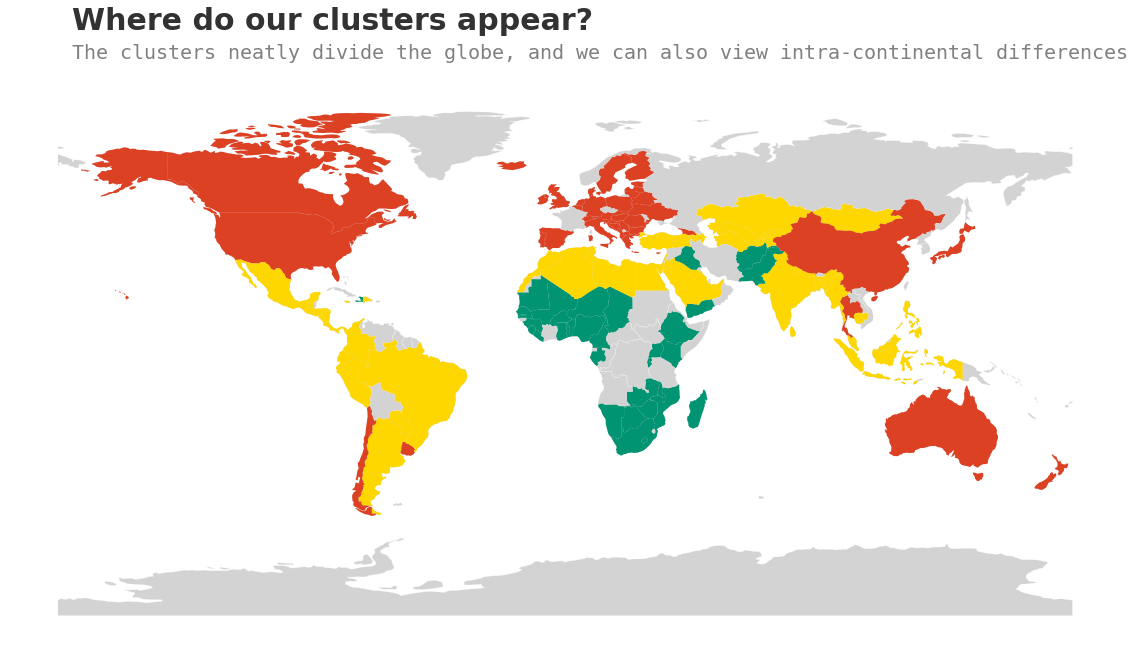

In [42]:
#data prep

geo_temp = refined_merge



#source: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE
# create a column for code 
geo_temp['CODE']=alpha3code(geo_temp['Country'])


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge=pd.merge(world,geo_temp,on='CODE')


###

# Custom colour map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [low_c,high_c,'gold'])

ax = world.plot(figsize=(20,15), linewidth=0.25, edgecolor=background_color, color='lightgray')
ax.axis('off')
ax.set_facecolor(background_color)
merge.plot(column='Cluster',figsize=(20, 15),legend=False,cmap=cmap,ax=ax)


ax.text(-175,112,'Where do our clusters appear?',fontsize=30,fontweight='bold',fontfamily='sansserif',color='#323232')
ax.text(-175,102,'The clusters neatly divide the globe, and we can also view intra-continental differences',color='gray',fontfamily='monospace',fontsize=20)

plt.show()

# Conclusions

We see that there are many clear distinctions between happy and unhappy countries - at least at the extremes. 

Generally, happier countries tend to:

- be wealthier

- be less populous

- have fewer children

- be older

- be less corrupt

- be more free

- have a lot of social support

Of course, a lot of these findings may come **as a result of** being wealthy, rather than be a cause of happiness in and of themselves.

We also know that, generally, the happy stay happy, and the unhappy are getting unhappier. 

However, as we have seen with Bulgaria - this does not have to be the case. Bulgaria improved by over 1.5 points between 2007 and 2020 - the most of any country. So there is hope that unhappy countries can break the historic trends.

Lastly, we clustered the data, using K-means and the elbow method. This enables us again to easily visualise and inderstand the differences between nations, and what features lead to high or low happiness index scores.
